In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genextreme
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.optimize import curve_fit, least_squares
import matplotlib as mpl
from fitter import Fitter
from Julia_Genextreme import Julia_Genextreme
import scipy.stats as stats
from analyzer import RainDataProcessor

import warnings
# Suprimir todas las advertencias
warnings.filterwarnings("ignore")

In [ ]:
import IDFAnalysis

In [54]:
# import data analysis libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme(style='ticks')

# import stats libraries
from fitter import Fitter
from scipy.stats import genextreme
from scipy.optimize import least_squares
from statsmodels.distributions.empirical_distribution import ECDF
from Julia_Genextreme import Julia_Genextreme
from scipy.optimize import curve_fit
import scipy.stats as stats
from math import ceil

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

class IDFAnalysis:
    """
    A class for performing Intensity-Duration-Frequency (IDF) analysis on rainfall data.
    
    This class encapsulates methods for calculating annual maximum intensities,
    fitting statistical models, generating IDF curves, and plotting results.
    """

    def __init__(self, historic_hourly, Durations, Return_periods, distribution='genextreme', model='scipy_stats', method='curve_fit', IDF_type='IDF_typeI'):
        """
        Initialize the IDFAnalysis class.
        
        Args:
            historic_hourly (pd.DataFrame): Historical hourly rainfall data.
            Durations (np.array): Array of durations to analyze (in hours)
            Return_periods (np.array): Array of return periods to calculate.
            distribution (str): Statistical distribution to use for fitting. Default is 'genextreme'.
            model (str): Model engine to use for fitting. Options are 'scipy_stats' or 'Julia_stats'. Default is 'scipy_stats'.
        """
        self.historic_hourly = historic_hourly
        self.Durations = Durations
        self.intensity_annual_max_dict = {}
        self.modelos_fit = {}
        self.Gages_idf = {}
        self.Return_period = Return_periods
        self.Non_Exceedance_Probability = 1 - 1 / self.Return_period
        self.distribution = distribution
        self.model = model
        self.method = method
        self.IDF_type = IDF_type
        
        # Perform initial calculations
        self._calculate_intensity_annual_max()
        self._fit_models()
        self._calculate_idf()

        # Dictionary to map IDF_type to their corresponding least_squares functions
        self.least_squares_funcs = {
            'IDF_typeI': self.IDF_typeI_least_squares,
            'IDF_typeII': self.IDF_typeII_least_squares,
            'IDF_typeIII': self.IDF_typeIII_least_squares,
            'IDF_typeIV': self.IDF_typeIV_least_squares,
            'IDF_typeV': self.IDF_typeV_least_squares
        }
        
    def _calculate_intensity_annual_max(self):
        """
        Calculate annual maximum intensities for each duration and station.
        """
        for station in self.historic_hourly.columns:
            int_h = pd.DataFrame(index=self.historic_hourly.index, columns=self.Durations)
            for duration in self.Durations:
                # Calculate rolling sum for each duration
                pcp_ = self.historic_hourly[station].rolling(duration, center=True).sum()
                # Convert to intensity (mm/hour)
                int_h[duration] = pcp_ / duration
            # Get annual maximum for each duration
            annualmax = int_h.groupby(by=int_h.index.year).max()
            self.intensity_annual_max_dict[station] = annualmax

    def _fit_models(self):
        """
        Fit statistical models to annual maximum intensities.
        """
        self.modelos_fit = self.fit_data()

    def fit_data(self):
        """
        Fit statistical models to the data.
        
        Returns:
            dict: Fitted models for each station and duration.
        """
        modelos_fit = {}
        
        for gage in self.historic_hourly.columns:
            modelos_gage = {}
            
            for duracion in self.Durations:
                data = self.intensity_annual_max_dict[gage][duracion]
                
                if self.model == 'scipy_stats':
                    f = Fitter(data, distributions=[self.distribution])
                    f.fit()
                    results = f.summary(plot=False).sort_values('aic')
                    distr = getattr(stats, results.index[0])
                    params = f.fitted_param[results.index[0]]
                    
                    # Create and save the fitted model
                    modelos_gage[duracion] = distr(*params)
                
                elif self.model == 'Julia_stats':
                    # Assuming Julia_Genextreme is a function that fits the parameters
                    Model_gev_fit_julia = Julia_Genextreme(data)
                    params = Model_gev_fit_julia.fit().values[0]
                    
                    # Create a scipy model with parameters calculated by Julia
                    modelos_gage[duracion] = stats.genextreme(*params)
            
            modelos_fit[gage] = modelos_gage
        
        return modelos_fit

    def _calculate_idf(self):
        """
        Calculate Intensity-Duration-Frequency (IDF) values for each station.
        """
        for station in self.historic_hourly.columns:
            IDF = pd.DataFrame(index=self.Return_period, columns=self.Durations)
            IDF.index.name = 'Tr'
            for duration in self.Durations:
                model = self.modelos_fit[station][duration]
                # Calculate intensity for each return period
                IDF.loc[:, duration] = model.ppf(self.Non_Exceedance_Probability)
            # Sort intensities in descending order for each return period
            df_sorted = IDF.apply(lambda row: sorted(row, reverse=True), axis=1, result_type='expand')
            df_sorted.columns = IDF.columns
            self.Gages_idf[station] = df_sorted.copy()
    
    def get_idf_table(self, station=None):
        """
        Get the IDF table for a specific station or all stations.
        
        Args:
            station (str, optional): The station name to get the IDF table for.
                                     If None, returns IDF tables for all stations.
        
        Returns:
            pd.DataFrame or dict of pd.DataFrames: The IDF table(s) for the specified station(s).
        """
        if station is not None:
            if station in self.Gages_idf:
                return self.Gages_idf[station]
            else:
                raise ValueError(f"Station '{station}' not found in the analysis.")
        else:
            return self.Gages_idf

    def plot_cdf_models(self, station):
        """
        Generate Cumulative Distribution Function (CDF) plots for a specific station.
        
        Args:
            station (str): The station to plot.
        
        Returns:
            matplotlib.figure.Figure: The generated figure.
        """
        n_plots = len(self.Durations)
        n_cols = min(3, n_plots)
        n_rows = ceil(n_plots / n_cols)
        
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5*n_cols, 4*n_rows), dpi = 90)
        fig.suptitle(f'CDF Plot - Station {station}', fontsize=16)
        
        if n_plots == 1:
            axes = np.array([axes])
        axes = axes.flatten()
        
        for ax, duration in zip(axes, self.Durations):
            data = self.intensity_annual_max_dict[station][duration]
            model = self.modelos_fit[station][duration]
            ecdf = ECDF(data)
            
            I = np.linspace(start=min(data)*0.8, stop=max(data)*1.2, num=1000)
            ax.plot(I, model.cdf(I), label='Fitted model', color='#1f77b4', linewidth=2)
            ax.scatter(data, ecdf(data), s=30, label='Observed data', color='#ff7f0e', alpha=0.7)
            
            ax.set_xlabel('Intensity (mm/h)', fontsize=10)
            ax.set_ylabel('Probability', fontsize=10)
            ax.set_title(f'Duration: {duration}h', fontsize=12)
            ax.legend(fontsize=9)
            ax.tick_params(labelsize=9)
            ax.grid(True, linestyle='--', alpha=0.7)
        
        # Hide empty subplots
        for ax in axes[n_plots:]:
            ax.set_visible(False)
        
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        return fig

    def plot_qq_models(self, station):
        """
        Generate Quantile-Quantile (Q-Q) plots for a specific station.
        
        Args:
            station (str): The station to plot.
        
        Returns:
            matplotlib.figure.Figure: The generated figure.
        """
        n_plots = len(self.Durations)
        n_cols = min(3, n_plots)
        n_rows = ceil(n_plots / n_cols)
        
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5*n_cols, 4*n_rows))
        fig.suptitle(f'Q-Q Plot - Station {station}', fontsize=16)
        
        if n_plots == 1:
            axes = np.array([axes])
        axes = axes.flatten()
        
        for ax, duration in zip(axes, self.Durations):
            data = self.intensity_annual_max_dict[station][duration]
            model = self.modelos_fit[station][duration]
            
            theoretical_quantiles = model.ppf(np.linspace(0.01, 0.99, len(data)))
            empirical_quantiles = np.sort(data)
            
            ax.scatter(theoretical_quantiles, empirical_quantiles, s=30, color='#2ca02c', alpha=0.7)
            
            # Add reference line y=x
            lims = [
                np.min([ax.get_xlim(), ax.get_ylim()]),
                np.max([ax.get_xlim(), ax.get_ylim()]),
            ]
            ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, linewidth=2)
            
            ax.set_xlabel('Theoretical Quantiles', fontsize=10)
            ax.set_ylabel('Empirical Quantiles', fontsize=10)
            ax.set_title(f'Duration: {duration}h', fontsize=12)
            ax.tick_params(labelsize=9)
            ax.grid(True, linestyle='--', alpha=0.7)
        
        # Hide empty subplots
        for ax in axes[n_plots:]:
            ax.set_visible(False)
        
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        return fig

    @staticmethod
    def IDF_typeI(x, b, c, d, e):
        """IDF equation type I."""
        a = d * x[0] + e
        I = a / (x[1] + c)**b
        return I

    @staticmethod
    def IDF_typeII(x, b, c, d, e):
        """IDF equation type II."""
        a = d * x[0] + e
        I = a / (x[1]**b + c)
        return I

    @staticmethod
    def IDF_typeIII(x, b, c, d, e):
        """IDF equation type III."""
        a = d * x[0]**e 
        I = a / (x[1] + c)**b
        return I

    @staticmethod
    def IDF_typeIV(x, b, c, d, e):
        """IDF equation type IV."""
        a = d * x[0]**e
        I = a / (x[1]**b + c)
        return I

    @staticmethod
    def IDF_typeV(x, b, c, d, e):
        """IDF equation type V."""
        a = d * x[0]**e
        I = a / (x[1])**b
        return I
    
    @staticmethod
    def IDF_typeI_least_squares(D, a, b, c):
        """IDF equation type I for least squares."""
        return a / (D + b)**2

    @staticmethod
    def IDF_typeII_least_squares(D, a, b, c):
        """IDF equation type II for least squares."""
        return a / (D**b + c)

    @staticmethod
    def IDF_typeIII_least_squares(D, a, b, c):
        """IDF equation type III for least squares."""
        return a / (D + c)**2

    @staticmethod
    def IDF_typeIV_least_squares(D, a, b, c):
        """IDF equation type IV for least squares."""
        return a / (D**c + c)

    @staticmethod
    def IDF_typeV_least_squares(D, a, b, c):
        """IDF equation type V for least squares."""
        return a / (D**c)

    def fit_multi_IDF_curves(self, x, params, func):
        """
        Fit multiple IDF curves simultaneously.
        
        Args:
            x (pd.DataFrame): DataFrame of observed IDF values.
            params (list): List of initial parameters.
            func (callable): Function of the IDF equation for least squares.
            
        Returns:
            np.array: Squared residuals between fitted and observed values.
        """
        y = pd.DataFrame().reindex_like(x)
        for idx, T in enumerate(x.index):
            y.loc[T, :] = func(x.loc[T].index.values.astype("float64"), params[idx+1], params[0], params[idx+8])
        return (y-x).values.reshape(-1)**2
    
    def residuo(self, params, IDF, func):
        """
        Calculate residuals for optimization.
        
        Args:
            params (list): List of initial parameters.
            IDF (pd.DataFrame): DataFrame of observed IDF values.
            func (callable): Function of the IDF equation for least squares.
            
        Returns:
            np.array: Squared residuals between fitted and observed values.
        """
        return self.fit_multi_IDF_curves(IDF, params, func)
    
    def construct_multi_IDFs(self, Ts, Ds, params, func):
        """
        Construct multiple synthetic IDF curves.
        
        Args:
            Ts (list): List of return periods.
            Ds (list): List of durations.
            params (list): List of optimized parameters.
            func (callable): Function of the IDF equation for least squares.
            
        Returns:
            pd.DataFrame: DataFrame of synthetic IDF curves.
        """
        res = pd.DataFrame(index=Ts, columns=Ds)
        for idx, T in enumerate(res.index):
            res.loc[T,:] = func(Ds, params[idx+1], params[0], params[idx+8])
        return res

    def IDF_fit(self, station, IDF_type=None, method=None, plot=True):
        """
        Fit the IDF curve for a specific station using the specified method.
        
        Args:
            station (str): Station to analyze.
            IDF_type (str): Type of IDF equation to use.
            method (str): Fitting method to use ('curve_fit' or 'least_squares').
            plot (bool): Whether to generate a plot of the results.
        
        Returns:
            pd.DataFrame: Fitted IDF curve data.
            matplotlib.figure.Figure: Generated figure (if plot=True).
        """
        if method is None:
            method = self.method  # Use class default method if not provided
        if IDF_type is None:
            IDF_type = self.IDF_type  # Use class default IDF_type if not provided
        
        station_idf = self.Gages_idf[station]
        
        # Point duration
        (RR, DD) = np.meshgrid(self.Return_period, self.Durations)
        Duracion_puntual = np.vstack([RR.reshape(-1), DD.reshape(-1)])
        
        # Intensity
        Intensidad_puntual = station_idf.melt()['value'].values
        
        # From 15 minutes to 24 hours
        Duracion_lluvia = np.linspace(0.01, self.Durations.max(), 1000)
        
        if method == 'curve_fit':
            # Fit curve using curve_fit
            params, _ = curve_fit(getattr(self, IDF_type), Duracion_puntual, Intensidad_puntual, maxfev=10000)
            
            IDF_curve_fit = pd.DataFrame(index=Duracion_lluvia)
            for tr in self.Return_period:
                Intensidad_lluvia = [getattr(self, IDF_type)((tr, duracion), *params) for duracion in Duracion_lluvia]
                IDF_curve_fit[tr] = Intensidad_lluvia
            
        elif method == 'least_squares':
            # Fit curve using least_squares
            ajuste = least_squares(self.residuo, x0=1.e-3*np.ones(15), args=(station_idf, self.least_squares_funcs[IDF_type]))
            synth_IDF = self.construct_multi_IDFs(station_idf.index, Duracion_lluvia, ajuste.x, self.least_squares_funcs[IDF_type])
            IDF_curve_fit = synth_IDF.T
        else:
            raise ValueError("Method must be 'curve_fit' or 'least_squares'")
        
        if plot:
            # Create plot of the results
            fig, ax = plt.subplots(figsize=(10, 6))
            colores = plt.cm.viridis(np.linspace(0, 1, len(IDF_curve_fit.columns)))
            
            for idx, tr in enumerate(self.Return_period):
                co = station_idf.loc[tr, :]
                cs = IDF_curve_fit[tr]
                ax.scatter(self.Durations, co.values, color=colores[idx], label=f'T = {tr} years (obs)', s=30, alpha=0.7)
                ax.plot(Duracion_lluvia, cs, color=colores[idx], linewidth=2)
            
            ax.set_xlim(0, 24)
            ax.set_xlabel('Duration (h)', fontsize=14)
            ax.set_ylabel('Intensity (mm/h)', fontsize=14)
            ax.set_title(f'IDF Curves - Station {station}', fontsize=16)
            ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
            ax.grid(True, which="both", ls="-", alpha=0.2)
            plt.tight_layout()
            
            return IDF_curve_fit, fig
        
        return synth_IDF.T

# Unificar series de lluvias horarias

Lo primero que vamos a realizar, es unir todas las series sintéticas generadas con ``COSMOS``. Para esto cargaremos las series generadas y las concatenaremos en un solo ``df``, ajustando en el índice las fechas.

In [21]:
historic_hourly = pd.DataFrame()
for gages_ in ['1121O', '1151', '1140E', 'A1144', '1153E']:
    pd_historic_hourly = pd.read_csv('data/'+ gages_ + '/SIM1/Time_serie_hourly_simulated_1980_2024.csv', index_col = 0, parse_dates=True)
    pd_historic_hourly.rename(columns={'Rain': gages_}, inplace=True)
    historic_hourly = pd.concat([historic_hourly, pd_historic_hourly], axis=1).round(5)
# Rename index
historic_hourly.index.name = 'date'
historic_hourly

1121O  1151    1140E  A1144    1153E
date                                                     
1980-01-01 00:00:00    0.0   0.0  0.00000    0.0  1.21413
1980-01-01 01:00:00    0.0   0.0  0.00636    0.0  0.00000
1980-01-01 02:00:00    0.0   0.0  0.05671    0.0  0.00000
1980-01-01 03:00:00    0.0   0.0  0.06069    0.0  0.00000
1980-01-01 04:00:00    0.0   0.0  0.17349    0.0  0.00000
...                    ...   ...      ...    ...      ...
2024-12-31 19:00:00    0.0   0.0  0.00000    0.0  0.00000
2024-12-31 20:00:00    0.0   0.0  0.00000    0.0  0.00000
2024-12-31 21:00:00    0.0   0.0  0.00000    0.0  0.00000
2024-12-31 22:00:00    0.0   0.0  0.00000    0.0  0.00000
2024-12-31 23:00:00    0.0   0.0  0.00000    0.0  0.00000

[394488 rows x 5 columns]

In [22]:
historic_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 394488 entries, 1980-01-01 00:00:00 to 2024-12-31 23:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   1121O   394488 non-null  float64
 1   1151    394488 non-null  float64
 2   1140E   394488 non-null  float64
 3   A1144   394488 non-null  float64
 4   1153E   394488 non-null  float64
dtypes: float64(5)
memory usage: 18.1 MB


# Calcular curvas intensidad-duación-frecuencia

2024-08-05 13:57:39.098 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted genextreme distribution with error=0.704256)
2024-08-05 13:57:39.128 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted genextreme distribution with error=0.569277)
2024-08-05 13:57:39.158 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted genextreme distribution with error=0.555044)
2024-08-05 13:57:39.192 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted genextreme distribution with error=1.366105)
2024-08-05 13:57:39.222 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted genextreme distribution with error=2.09869)
2024-08-05 13:57:39.249 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted genextreme distribution with error=2.844224)
2024-08-05 13:57:39.280 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted genextreme distribution with error=9.205417)
2024-08-05 13:57:39.313 | INFO     | fitter.fitter:_fit_single_

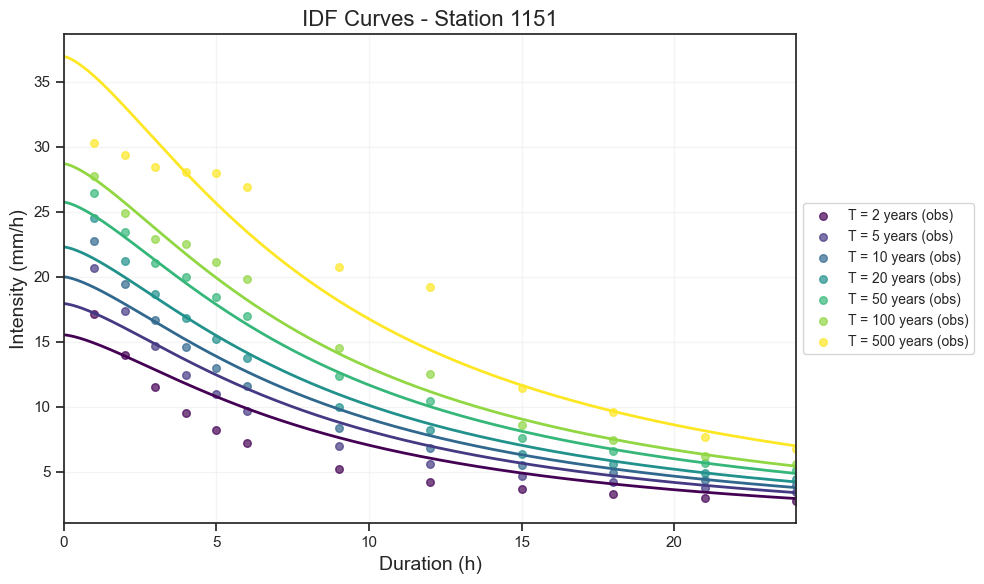

In [77]:
Durations = np.array([1, 2, 3, 4, 5, 6, 9, 12, 15, 18, 21, 24])
Return_periods = np.array([2, 5, 10, 20, 50, 100, 500])

idf_analysis = IDFAnalysis(historic_hourly, Durations, Return_periods, distribution='genextreme', model='scipy_stats', method='curve_fit', IDF_type='IDF_typeIV')
synth_IDF, idf_fig = idf_analysis.IDF_fit(station, plot=True)

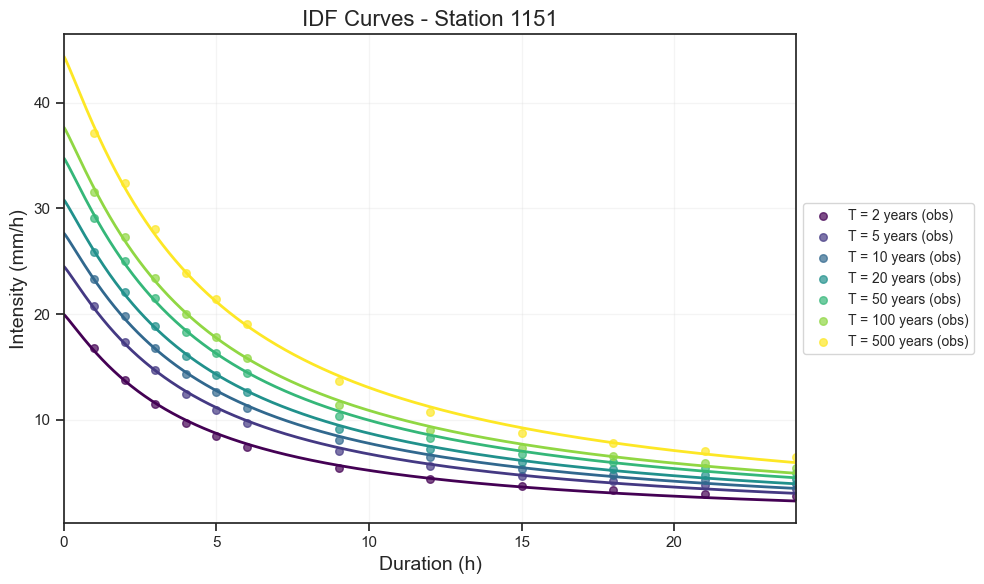

In [56]:
synth_IDF, idf_fig = idf_analysis.IDF_fit(station, plot=True)

In [29]:
station = historic_hourly.columns[1]

In [37]:
station_idf = idf_analysis.get_idf_table(station)

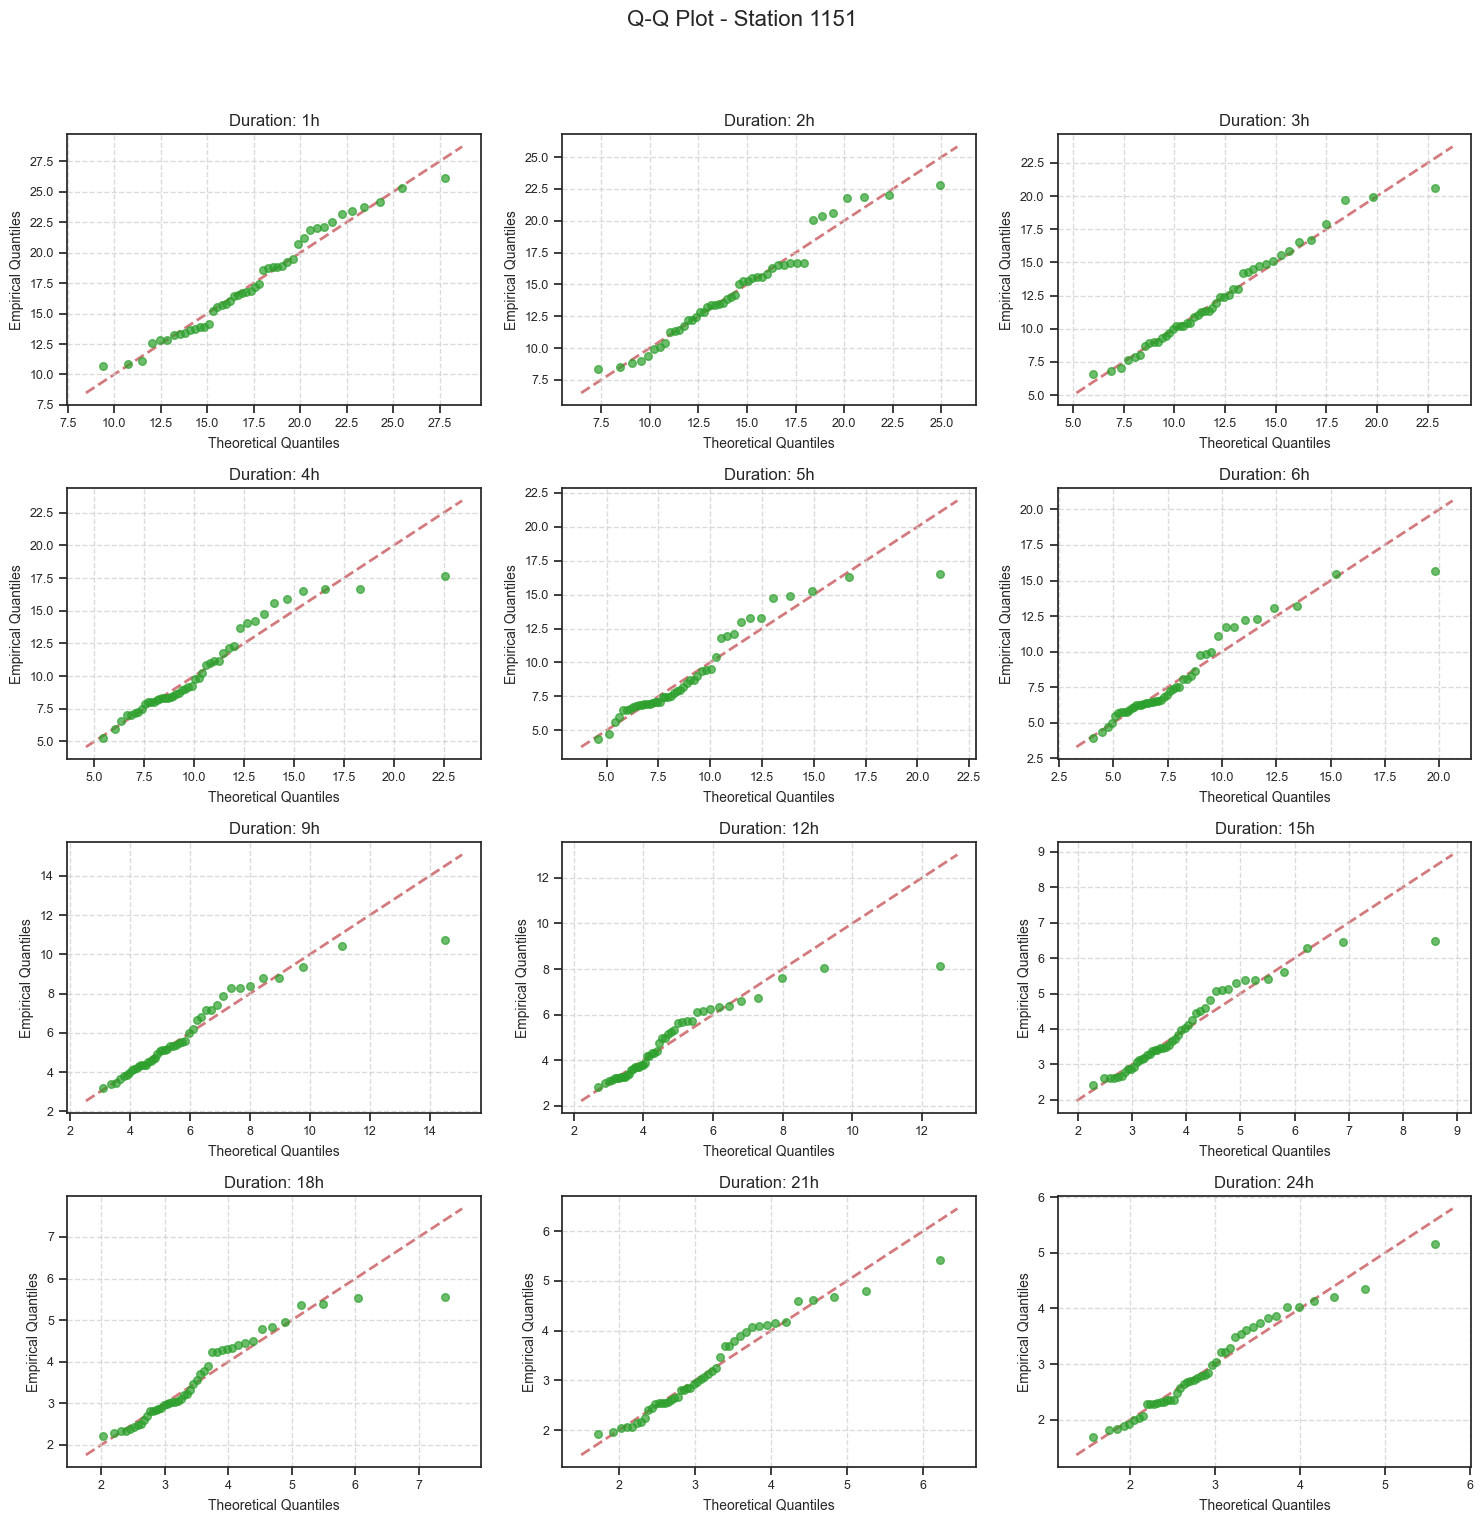

In [31]:
df_fig = idf_analysis.plot_qq_models(station)

In [ ]:
# Generate CDF plot for a specific station
# station = historic_hourly.columns[1]
# cdf_fig = idf_analysis.plot_cdf_models(station)
# cdf_fig.savefig(f'cdf_plot_{station}.png', dpi=300, bbox_inches='tight')
# plt.close(cdf_fig)

# Create IDF table for a specific station
station_idf = idf_analysis.get_idf_table(station)

# Generate Q-Q plot for a specific station
# qq_fig = idf_analysis.plot_qq_models(station)
# qq_fig.savefig(f'qq_plot_{station}.png', dpi=300, bbox_inches='tight')
# plt.close(qq_fig)

# Fit and plot IDF fit curves for a specific station
synth_IDF, idf_fig = idf_analysis.Fit_IDF(station, plot=True)
# idf_fig.savefig(f'idf_curves_{station}.png', dpi=300, bbox_inches='tight')
# plt.close(idf_fig)

In [50]:
intensity_annual_max_dict = {}
# Repitiendo el procedimiento anterior para 1, 2, 4, 8, 16, 24 horas tenemos:
Durations = np.array([1, 2, 3, 4, 5, 6, 9, 12, 15, 18, 21, 24])

int_h = pd.DataFrame(index=historic_hourly.index, columns=Durations)

for i,ii in enumerate(historic_hourly.columns):
    for duration in Durations:
        pcp_ = historic_hourly[ii].rolling(duration, center=True).sum()
        int_h[duration] = pcp_/duration
    annualmax = int_h.groupby(by=int_h.index.year).max()
    intensity_annual_max_dict[ii] = annualmax

In [208]:
intensity_annual_max_dict['1151']

1          2          3          4          5          6   \
date                                                                    
1980  17.17400  16.690775  14.918953  14.033043  13.008566  12.199190   
1981  16.82530  13.975945   9.317297   7.285958   6.919076   5.905373   
1982  19.21645  16.654255  14.704667  14.249125  13.254660  11.724085   
1983  13.93189   9.391025   6.831387   6.596382   6.518184   6.385787   
1984  10.66403   8.526515   6.622790   5.287058   4.393120   4.322700   
1985  14.12298  12.224180  10.201943   8.360375   6.753870   6.336358   
1986  21.19368  15.562930  15.562930  15.562930  15.251672  13.228492   
1987  18.80568  16.555770  11.349553   8.512165   6.809732   6.937240   
1988  25.31433  15.821455  13.010930   9.758198   7.955718   7.513722   
1989  21.85772  20.045430  17.884987  15.878568  14.935150  13.066040   
1990  16.45506  13.381300  10.416903   8.338545   7.776478   6.507675   
1991  13.93661  12.194535  11.032030   9.882860   7.906288   6.588573   
1992  20.73650  15.561295  11.916580   9.276535   8.735592   8.623427   
1993  19.50782  15.281125  12.571707  12.294450  12.130524  11.713878   
1994  26.16471  21.803970  15.117427  12.135285  10.374136   9.737640   
1995  16.67977  16.679770  16.679770  16.679770  16.290576  15.660452   
1996  16.52591  16.525690  16.525617  16.525580  16.525558  15.469750   
1997  10.89620   8.317305   7.022380   7.022380   7.022380   6.008037   
1998  15.71084  11.225255   9.036923   7.166605   6.547814   5.768597   
1999  15.81782  11.410275   7.614750   7.030945   5.624756   4.687297   
2000  16.79630  16.247480  15.875293  13.671743  11.946122   9.955102   
2001  11.08696  10.070655   8.933687   8.933685   8.487000   7.395105   
2002  13.31506   9.889030   7.898170   5.923628   4.738902   3.949093   
2003  13.38821  13.388210  12.421283  10.264295   8.211436   6.842863   
2004  23.20747  13.862030  10.245643   8.142735   6.860290   6.541465   
2005  23.77926  22.789075  20.577113  16.631095  13.307840  11.092337   
2006  13.71993  12.855075  10.017533   7.990713   7.436202   6.252167   
2007  12.83302  12.833020  10.195120   8.287990   6.862574   5.718812   
2008  18.89631  15.252210  14.235397  11.756913   9.405530   8.320283   
2009  13.27140   8.848370   8.015427   8.015295   7.111586   6.482912   
2010  22.53062  20.602840  14.291730  10.856703   8.685362   7.237802   
2011  18.54897  13.448000  11.541580   8.656185   6.933346   5.777788   
2012  15.21118  12.433560  12.379617  11.182668   9.470090   8.058383   
2013  22.02013  21.845170  19.903377  17.669275  14.779920  12.319242   
2014  18.84194  13.198195   9.711713   8.710030   7.059460   6.460742   
2015  12.56497   9.012145   8.977560   8.229430   6.942646   5.785538   
2016  23.38374  15.027435  10.883070   8.383593   7.093890   6.119382   
2017  17.45551  14.143400   9.428933   7.480338   5.984344   5.010940   
2018  22.08906  22.015295  19.708260  14.781195  11.824956   9.854130   
2019  24.18988  20.359815  14.513927  11.182760   9.032700   7.527250   
2020  16.05305  15.483200  13.016450  10.990190   9.512492   8.043770   
2021  12.82684  11.757935  10.475250   7.856438   6.521120   5.496673   
2022  13.68891  11.339240  11.339240   9.026605   7.485866   6.240547   
2023  15.53405  10.431020   8.708410   8.018295   7.507122   6.375165   
2024  18.71600  13.501485  11.253550   9.142013   7.487508   6.253995   

             9         12        15        18        21        24  
date                                                               
1980   8.782023  6.721220  5.376976  4.781802  4.120314  3.609288  
1981   5.143809  3.864115  3.192015  2.816050  2.435597  2.288322  
1982   8.308002  6.231002  5.141493  4.496710  3.884764  3.481358  
1983   5.978658  5.675627  5.395632  4.946828  4.665238  4.343947  
1984   3.414212  2.993596  3.395309  2.967864  2.543883  2.291329  
1985   5.317700  4.319332  3.666204  3.190326  3.026302  2.690167  
1986   8.818994  6.614246  5.291397 

# Ajustar intensidades máximas a la distribución GEV

Ajustamos las intensidades máximas a la distribución GEV usando dos optimizadores diferentes:
* Scipy
* Julia
  
Este procedimiento lo hacemos, porque generalemente el modulo de ``scipy`` algunas veces no ajusta bien la Gev.

In [282]:
def fit_data(historic_hourly, Durations, intensity_annual_max_dict, distribution = 'genextreme', model = 'Julia_stats'):
    modelos_fit = {}

    for gage in historic_hourly.columns:
        modelos_gage = {}

        for duracion in Durations:
            data = intensity_annual_max_dict[gage][duracion]

            if model == 'scipy_stats':
                f = Fitter(data, distributions=[distribution])
                f.fit()
                results = f.summary(plot=False).sort_values('aic')
                distr = getattr(stats, results.index[0])
                params = f.fitted_param[results.index[0]]
                
                # Crear y guardar el modelo ajustado
                modelos_gage[duracion] = distr(*params)

            elif model == 'Julia_stats':
                # Asumimos que Julia_Genextreme es una función que ajusta los parámetros
                Model_gev_fit_julia = Julia_Genextreme(data)
                params = Model_gev_fit_julia.fit().values[0]
                
                # Crear un modelo de scipy con los parámetros calculados por Julia
                modelos_gage[duracion] = stats.genextreme(*params)

        modelos_fit[gage] = modelos_gage

    return modelos_fit

In [328]:
# Optimizador julia
Model_fit_gev_julia = fit_data(historic_hourly, Durations, intensity_annual_max_dict, distribution = 'genextreme', model = 'Julia_stats')

In [329]:
# Optimizador de scipy
Model_fit_scipy = fit_data(historic_hourly, Durations, intensity_annual_max_dict, distribution = 'gumbel_r', model = 'scipy_stats')

2024-08-05 09:15:20.835 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gumbel_r distribution with error=0.703711)


2024-08-05 09:15:20.855 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gumbel_r distribution with error=0.579009)
2024-08-05 09:15:20.875 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gumbel_r distribution with error=0.564012)
2024-08-05 09:15:20.894 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gumbel_r distribution with error=1.372593)
2024-08-05 09:15:20.916 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gumbel_r distribution with error=2.100193)
2024-08-05 09:15:20.937 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gumbel_r distribution with error=2.845413)
2024-08-05 09:15:20.957 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gumbel_r distribution with error=9.239242)
2024-08-05 09:15:20.977 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gumbel_r distribution with error=7.623322)
2024-08-05 09:15:20.996 | INFO     | fitter.fitter:_fit_single_distribution:


Para revisar la calidad de los ajustes se puede usar la ``cdata``. A pesar que hay mejores vias para evaluar el ajuste vamos a usar las ``cdata``, en este caso se pueden gráficar los ``parametros_fit_gev_scipy`` o los ``parametros_fit_gev_julia``.

En este caso los dos modelos funcionaron bien, sin embargo, por seleccionar alguno, nos quedamos con julia.

In [321]:
def plot_cdf_models(intensity_annual_max_dict, modelos_fit, Durations, historic_hourly):
    sns.set_theme(style='ticks')
    I = np.linspace(start=0, stop=70, num=1000)
    
    figures = {}
    
    for gage in historic_hourly.columns:
        # Determinar el número de filas y columnas para los subplots
        n_plots = len(Durations)
        n_cols = min(3, n_plots)  # Máximo 3 columnas
        n_rows = ceil(n_plots / n_cols)
        
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5*n_cols, 4*n_rows))
        fig.suptitle(f'Estación {gage}', fontsize=16)
        
        if n_plots == 1:
            axes = np.array([axes])
        axes = axes.flatten()
        
        for ax, duracion in zip(axes, Durations):
            data = intensity_annual_max_dict[gage][duracion]
            model = modelos_fit[gage][duracion]
            ecdf = ECDF(data)
            
            ax.plot(I, model.cdf(I), label='Modelo ajustado', color = 'red', lw = 2, ls = '--')
            ax.scatter(data, ecdf(data), s=8, label='Datos observados', color = 'royalblue')
            
            ax.set_xlabel('Intensidad (mm/h)', fontsize=10)
            ax.set_ylabel('Probabilidad', fontsize=10)
            ax.set_title(f'Duration: {duracion}h', fontsize=12)
            ax.legend(fontsize=8)
            ax.tick_params(labelsize=8)
            ax.set_xlim(data.min()-1, data.max()+1)
        
        # Ocultar subplots vacíos
        for ax in axes[n_plots:]:
            ax.set_visible(False)
        
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar el espacio para el título principal
        figures[gage] = fig
    
    return figures

In [322]:
def plot_qq_models(intensity_annual_max_dict, modelos_fit, Durations, historic_hourly):
    sns.set_theme(style='ticks')
    
    figures = {}
    
    for gage in historic_hourly.columns:
        n_plots = len(Durations)
        n_cols = min(3, n_plots)
        n_rows = ceil(n_plots / n_cols)
        
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5*n_cols, 4*n_rows))
        fig.suptitle(f'Q-Q Plot - Estación {gage}', fontsize=16)
        
        if n_plots == 1:
            axes = np.array([axes])
        axes = axes.flatten()
        
        for ax, duracion in zip(axes, Durations):
            data = intensity_annual_max_dict[gage][duracion]
            model = modelos_fit[gage][duracion]
            
            # Calcular cuantiles teóricos y empíricos
            theoretical_quantiles = model.ppf(np.linspace(0.01, 0.99, len(data)))
            empirical_quantiles = np.sort(data)
            
            # Graficar Q-Q plot
            ax.scatter(theoretical_quantiles, empirical_quantiles, s=5)
            
            # Añadir línea de referencia y = x
            lims = [
                np.min([ax.get_xlim(), ax.get_ylim()]),
                np.max([ax.get_xlim(), ax.get_ylim()]),
            ]
            ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
            
            ax.set_xlabel('Cuantiles teóricos', fontsize=10)
            ax.set_ylabel('Cuantiles empíricos', fontsize=10)
            ax.set_title(f'Duración: {duracion}h', fontsize=12)
            ax.tick_params(labelsize=8)
        
        # Ocultar subplots vacíos
        for ax in axes[n_plots:]:
            ax.set_visible(False)
        
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        figures[gage] = fig
    
    return figures

In [323]:
from math import ceil, sqrt

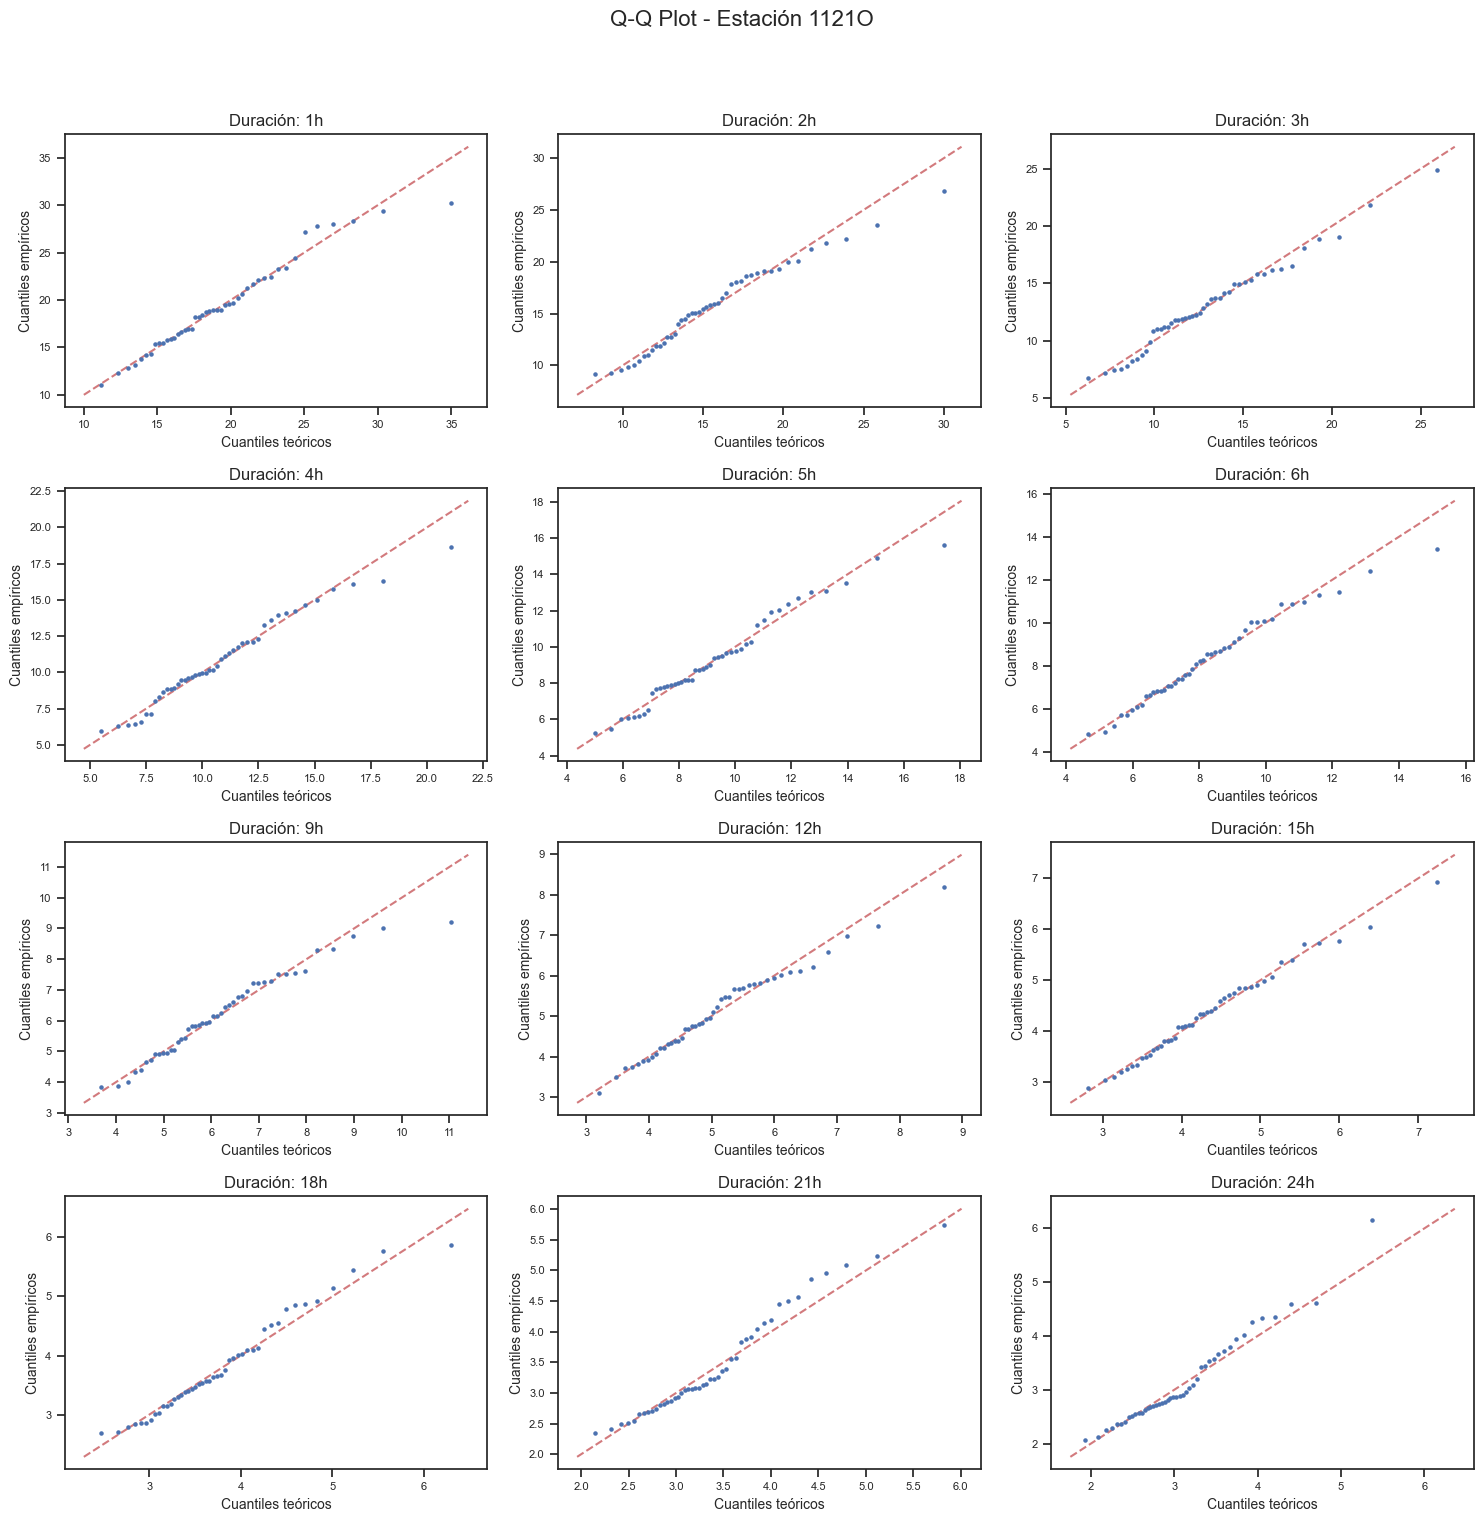

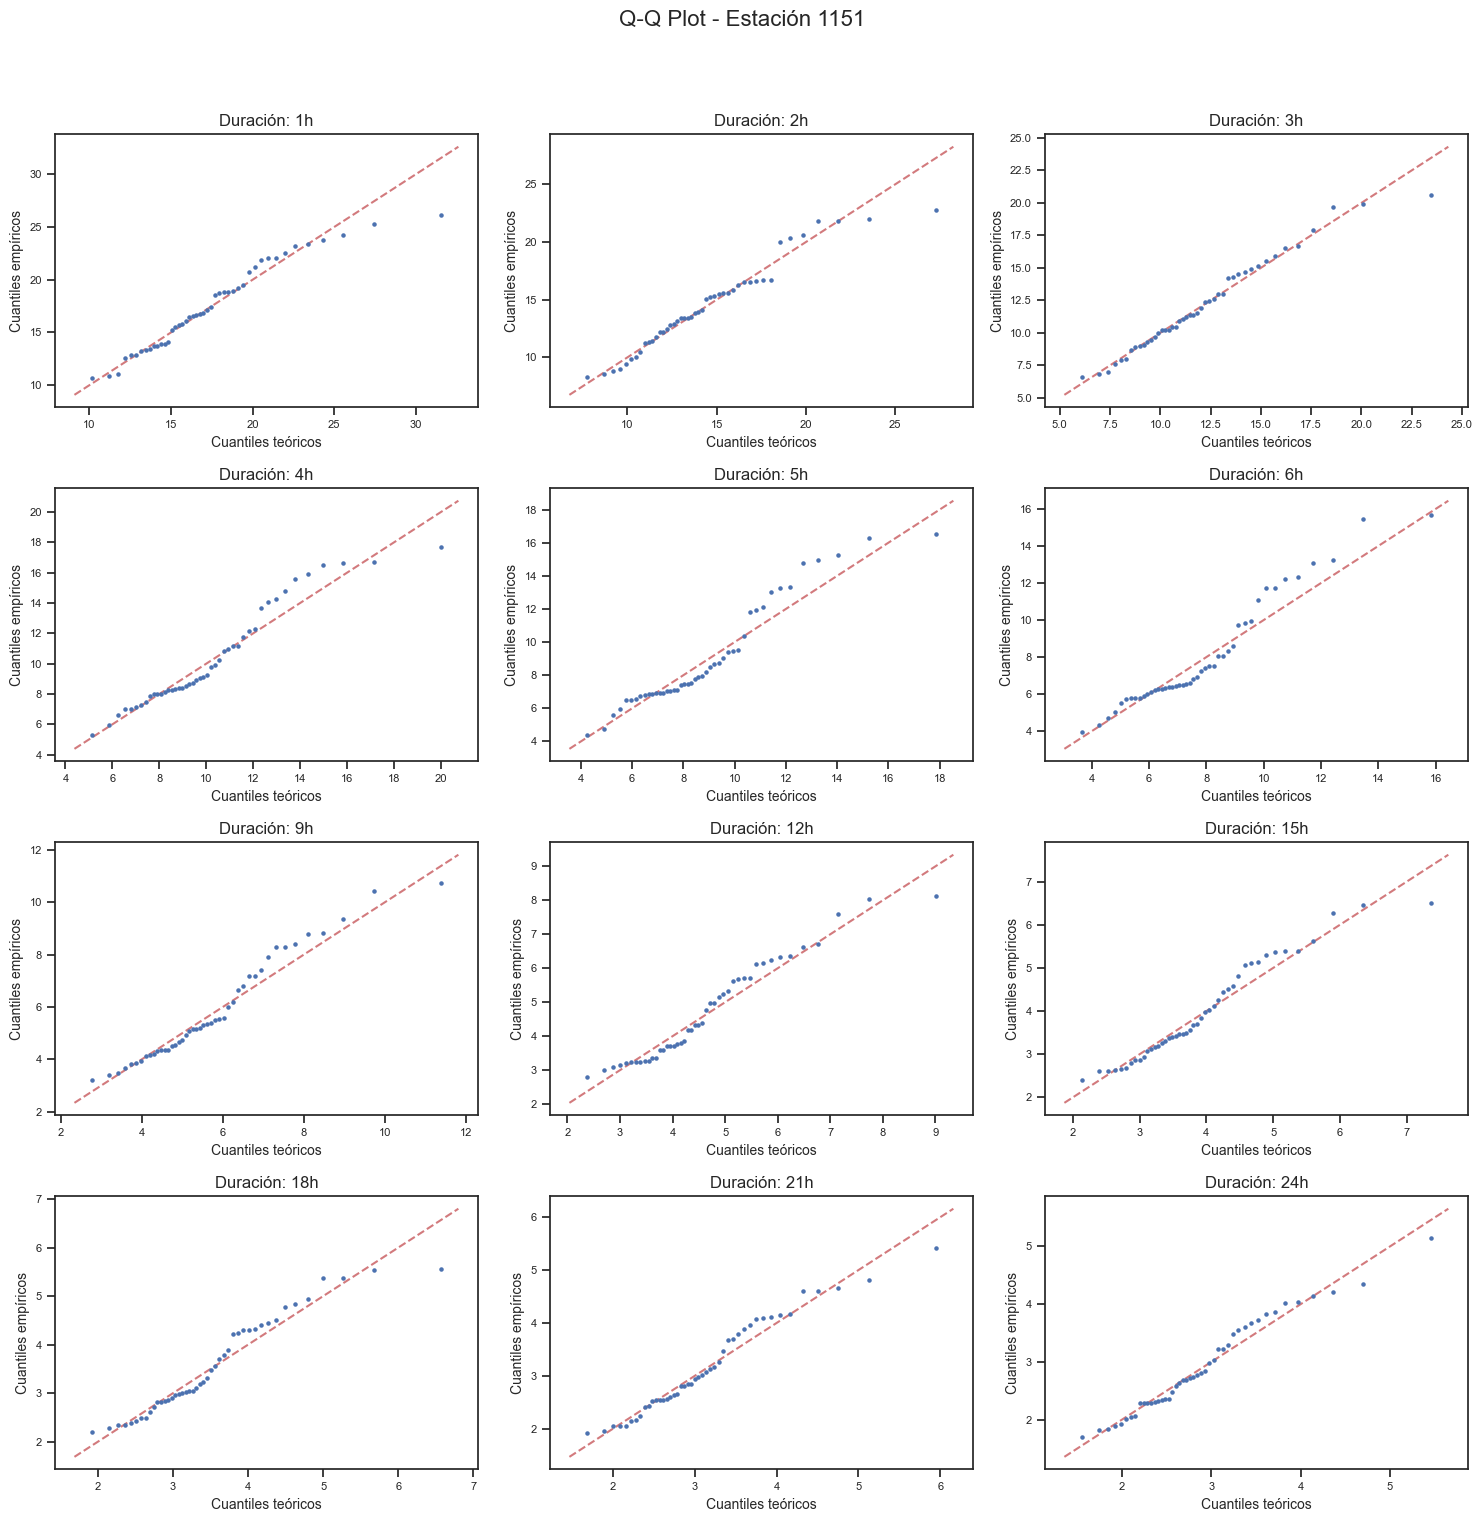

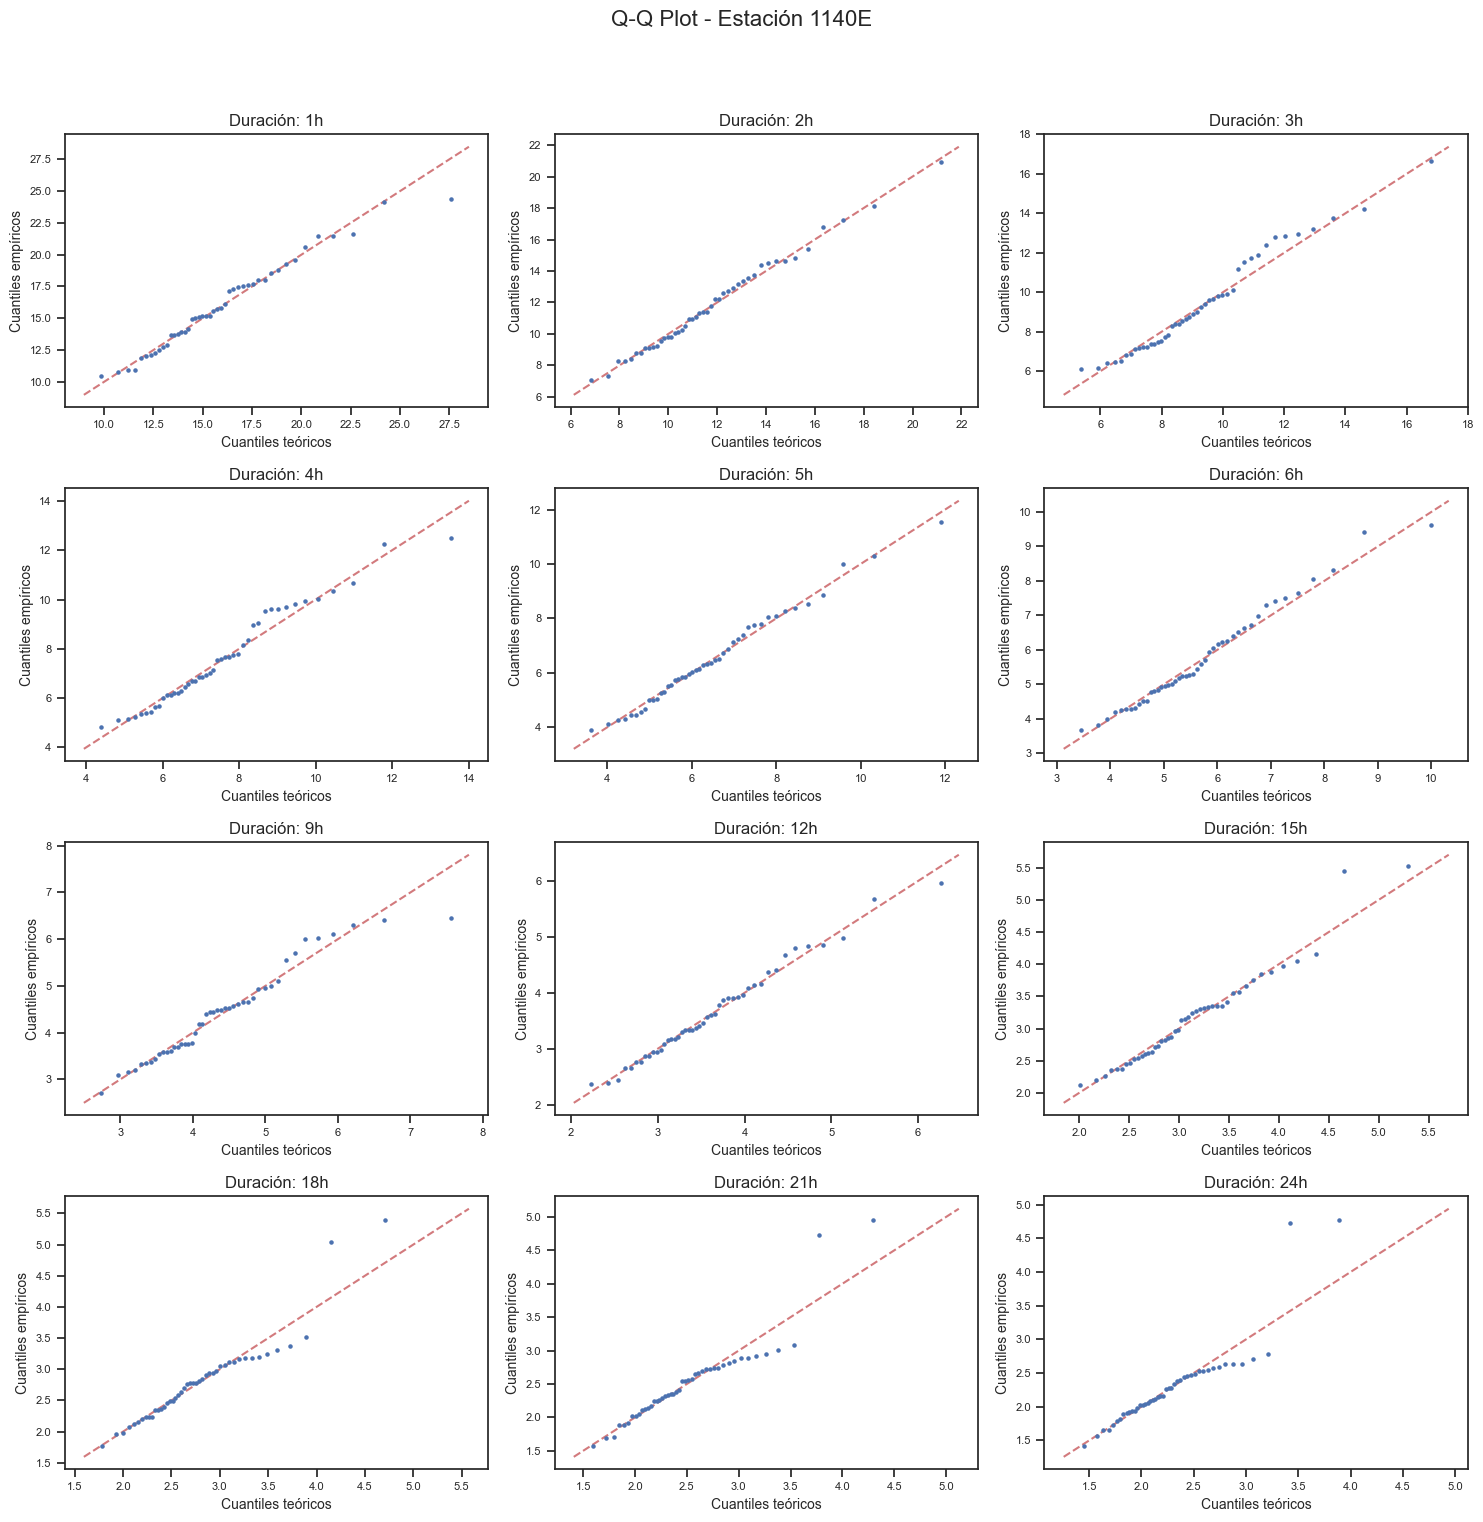

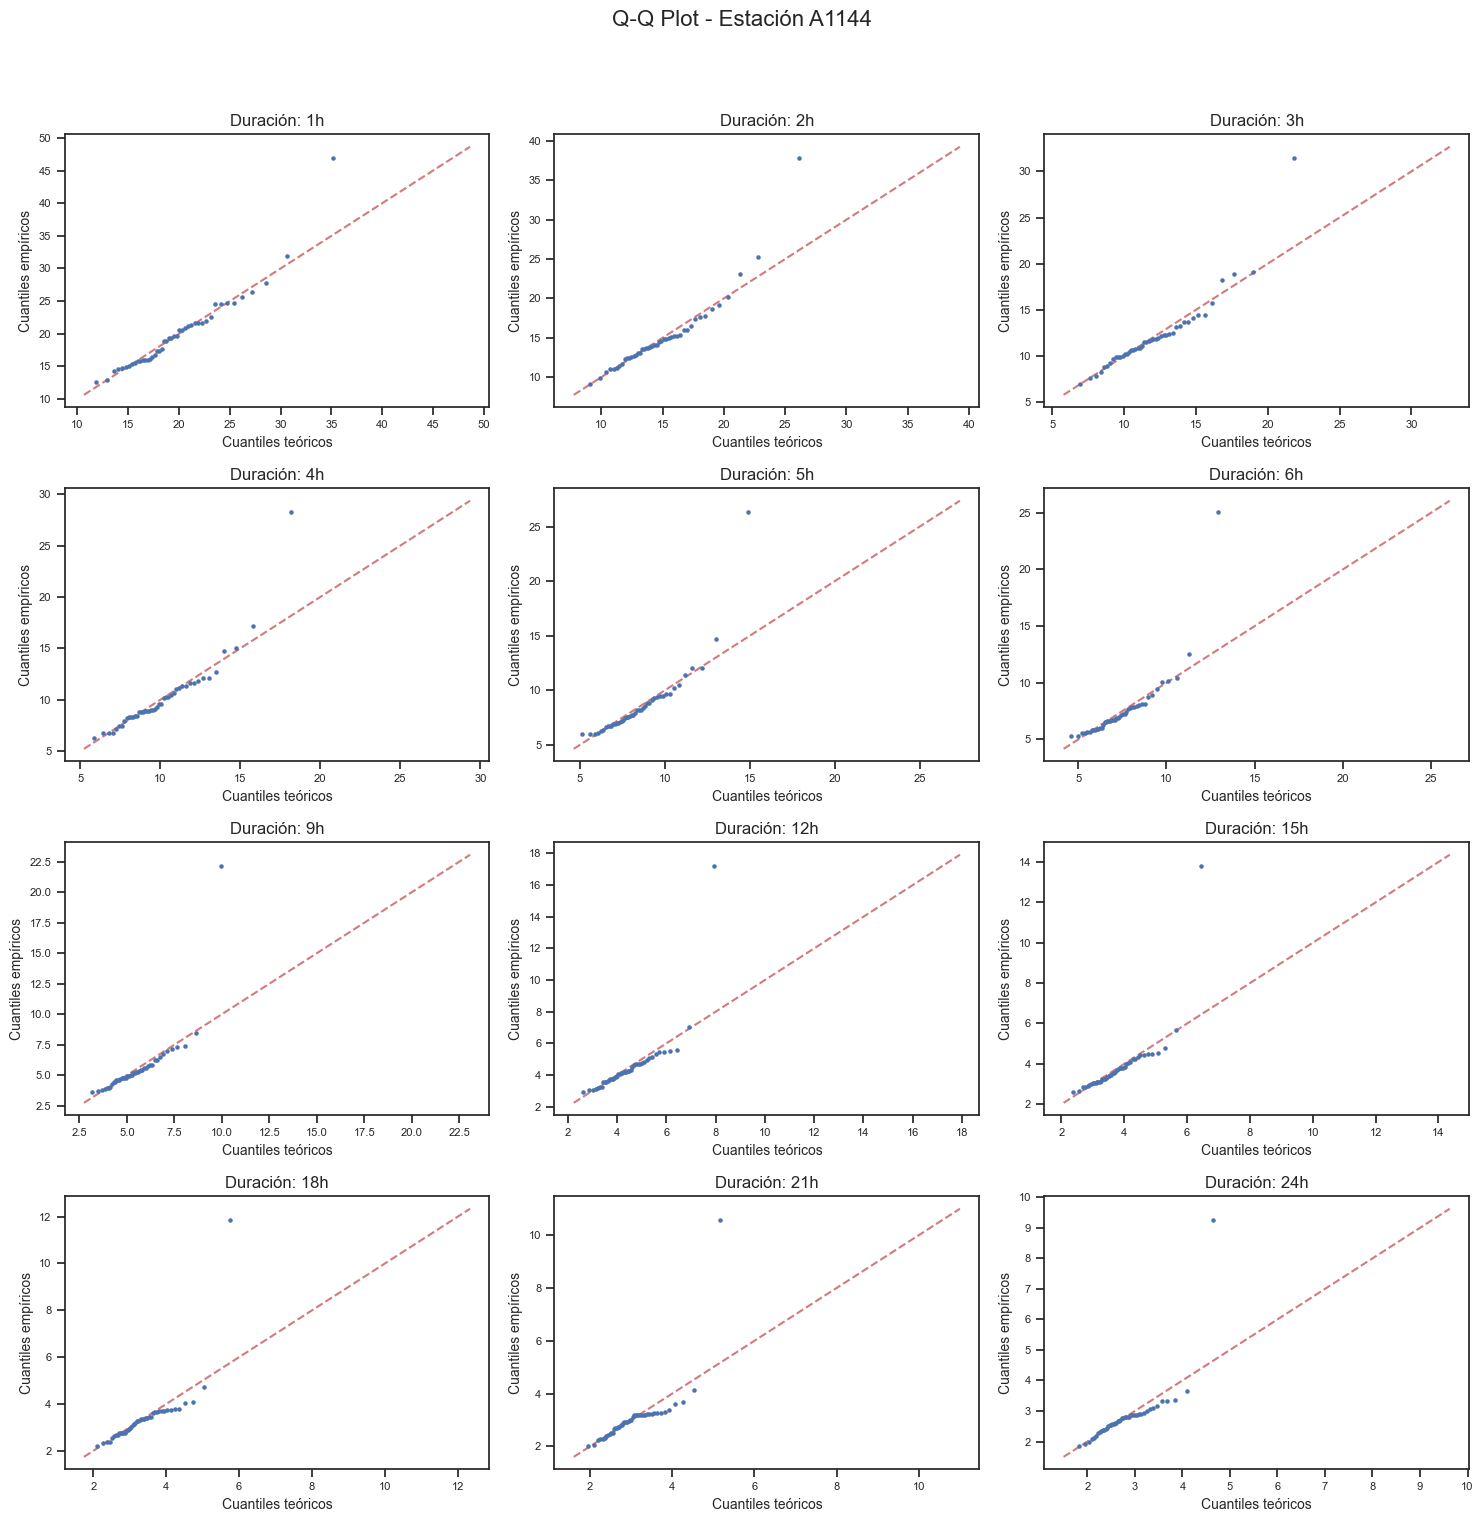

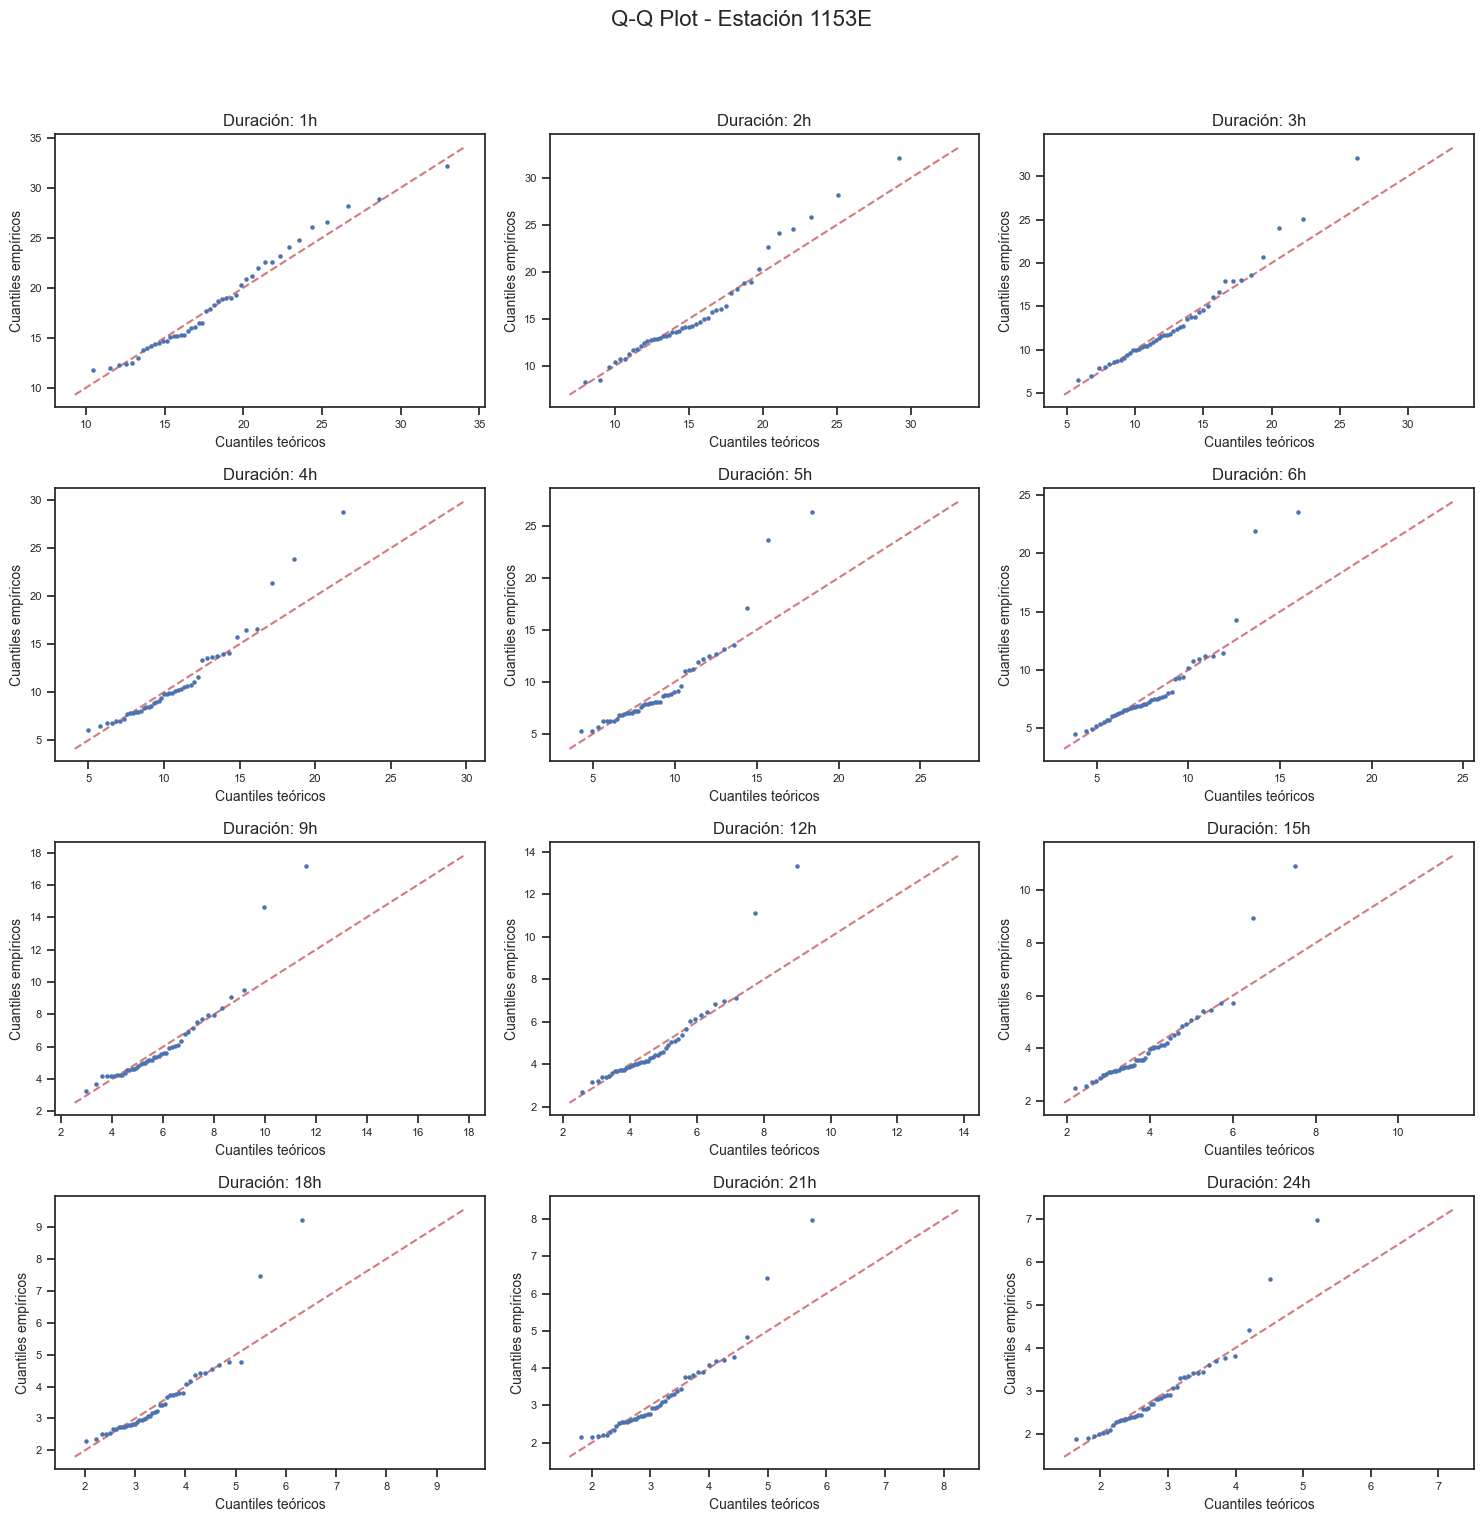

In [326]:
figures_qq = plot_qq_models(intensity_annual_max_dict, Model_fit_scipy, Durations, historic_hourly)

{'1121O': <Figure size 1500x1600 with 12 Axes>,
 '1151': <Figure size 1500x1600 with 12 Axes>,
 '1140E': <Figure size 1500x1600 with 12 Axes>,
 'A1144': <Figure size 1500x1600 with 12 Axes>,
 '1153E': <Figure size 1500x1600 with 12 Axes>}

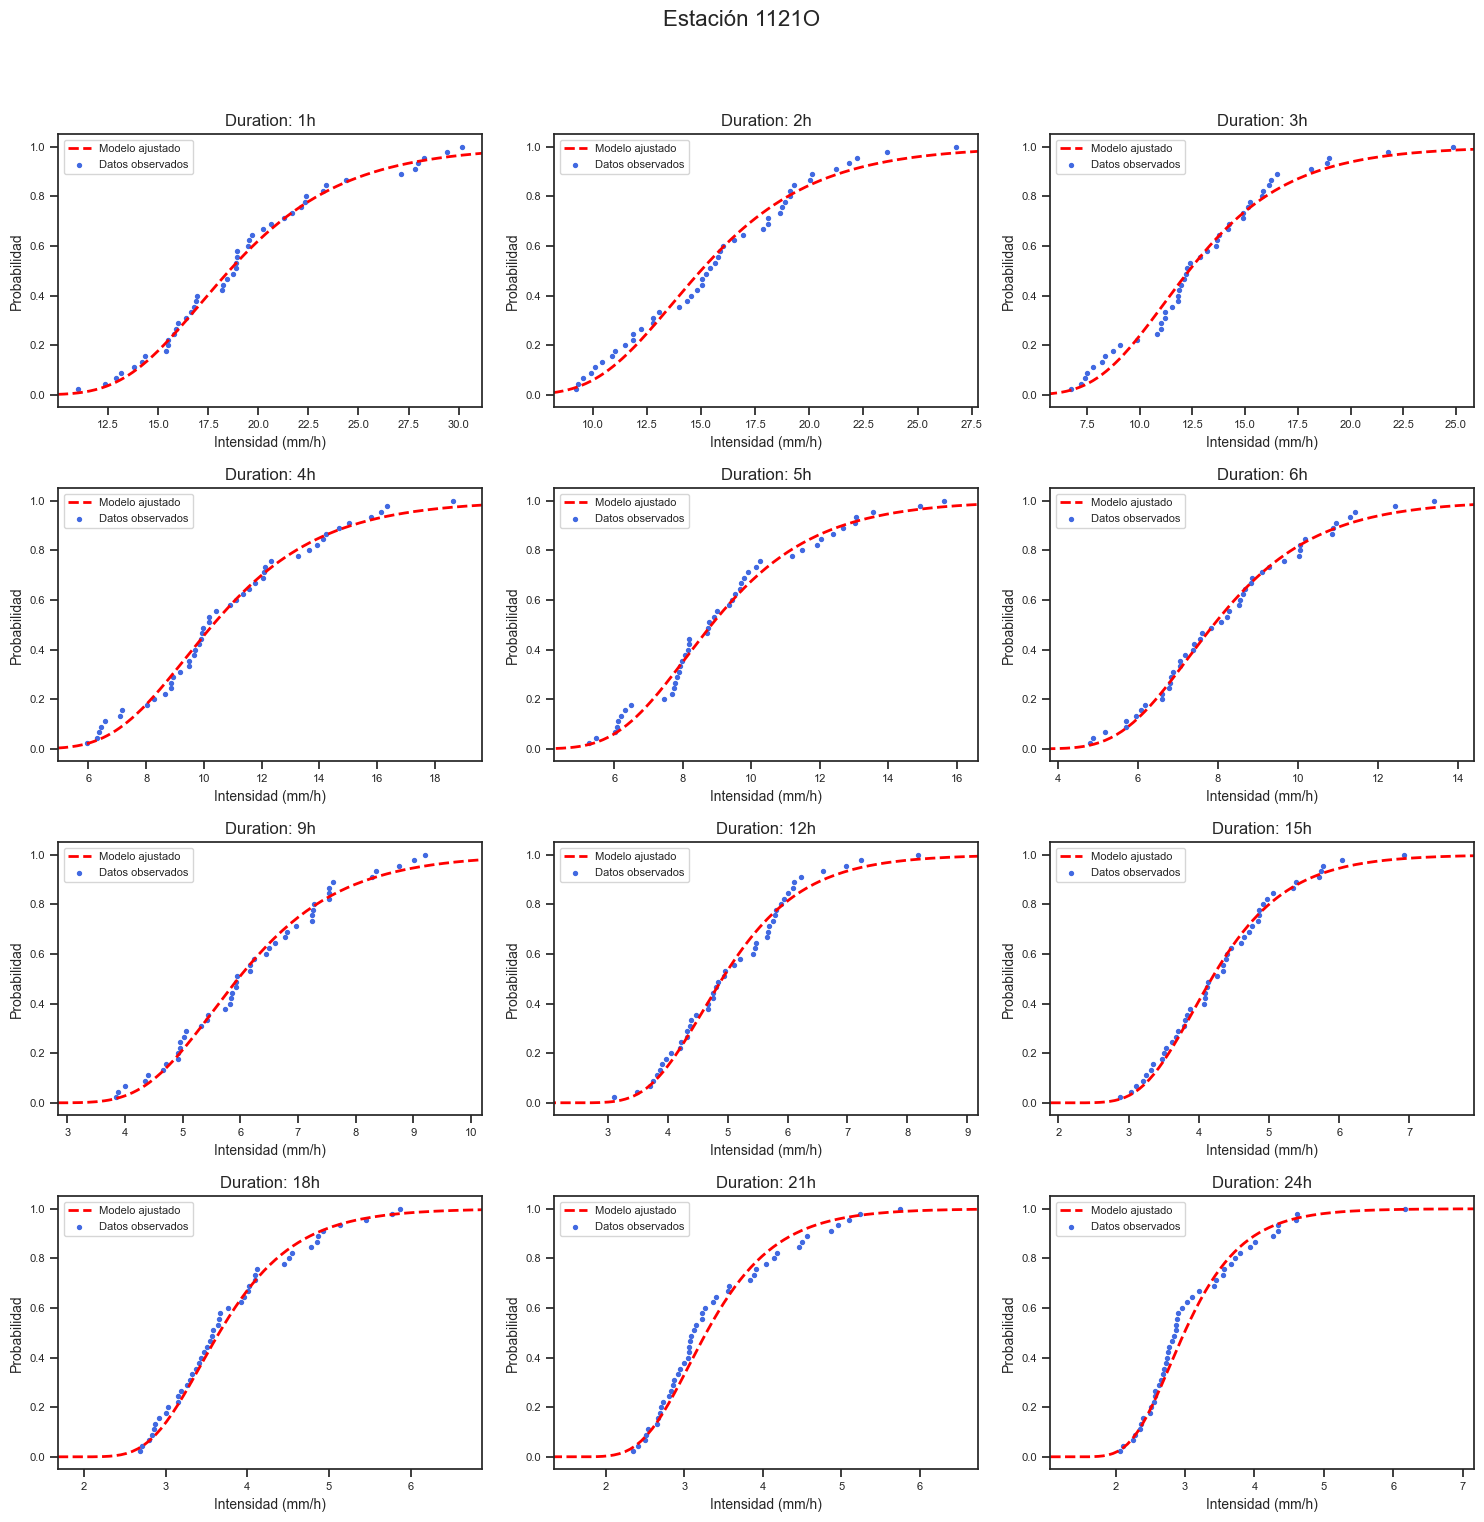

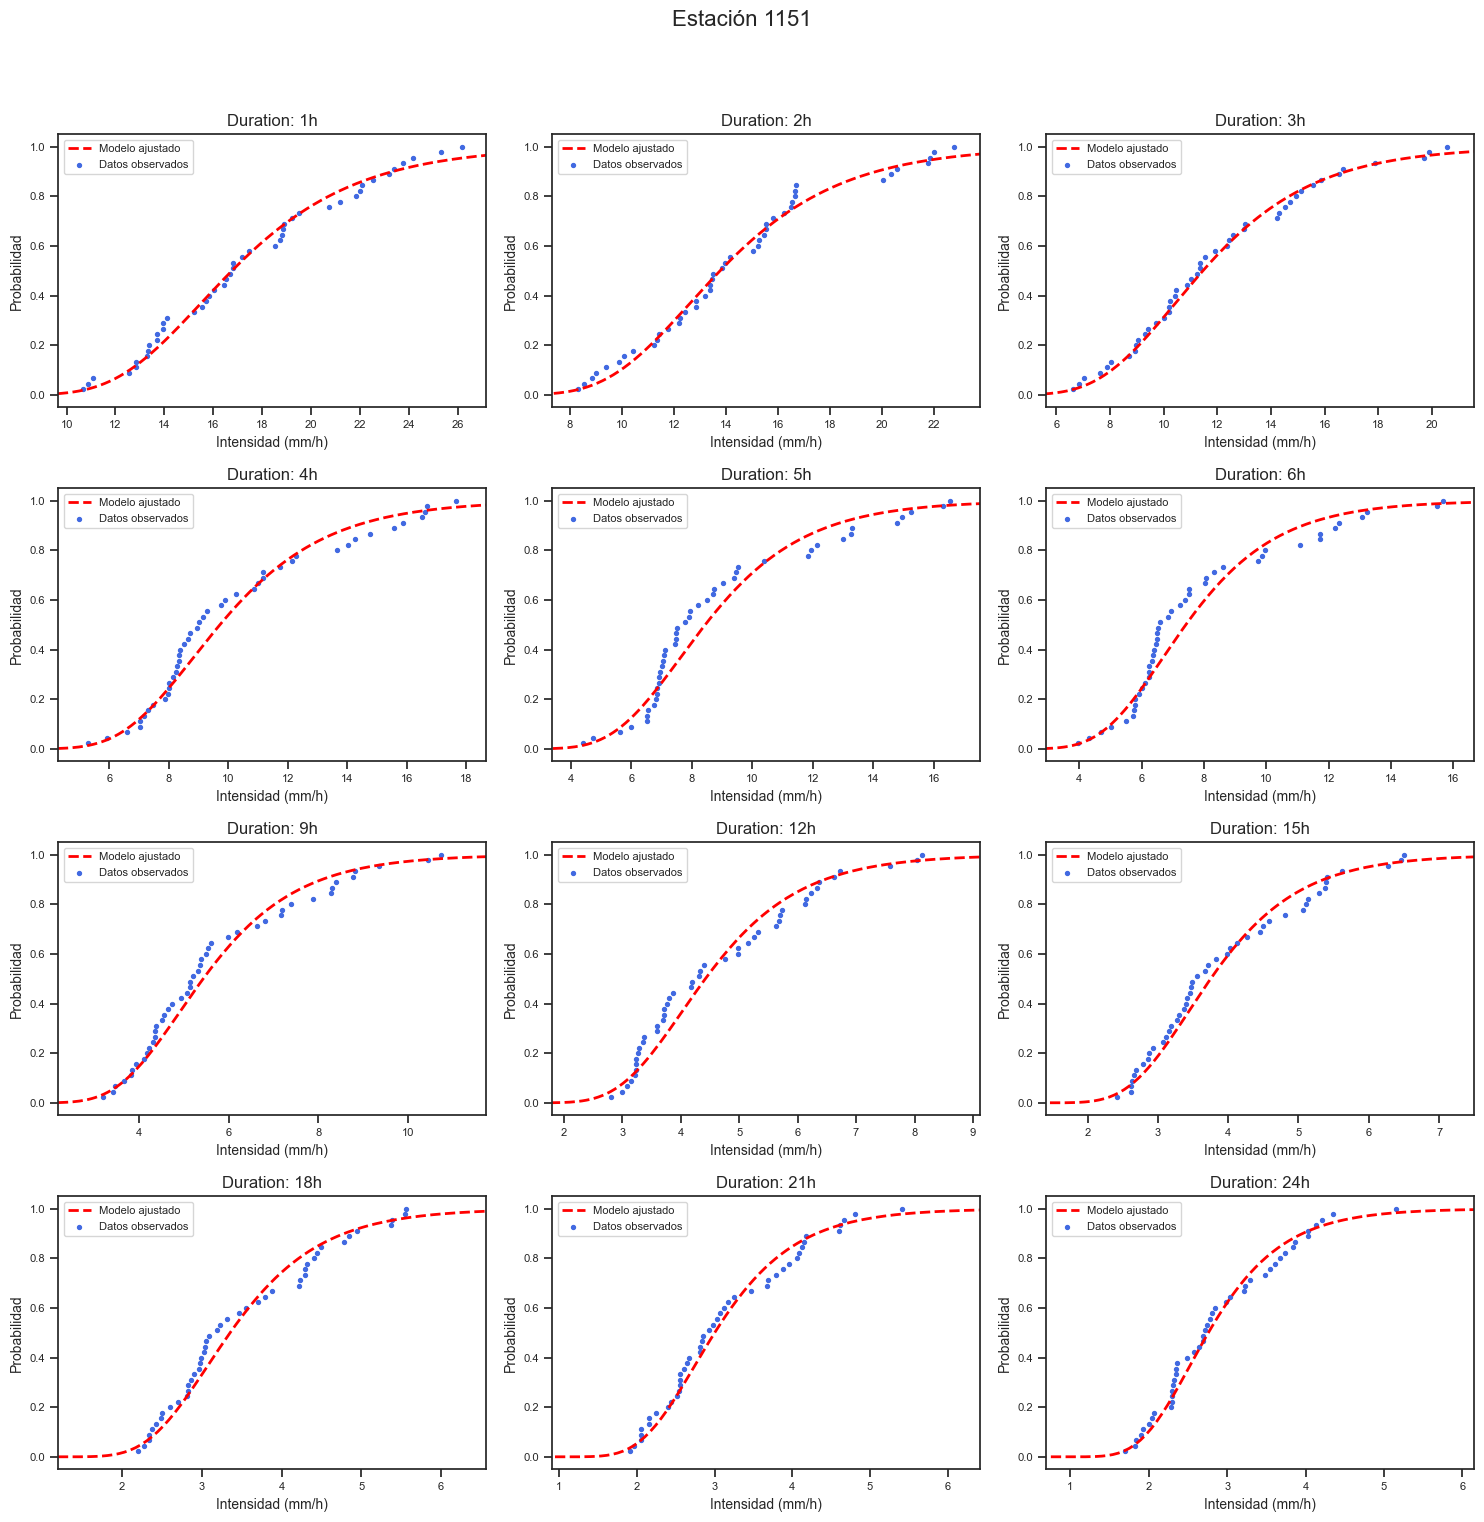

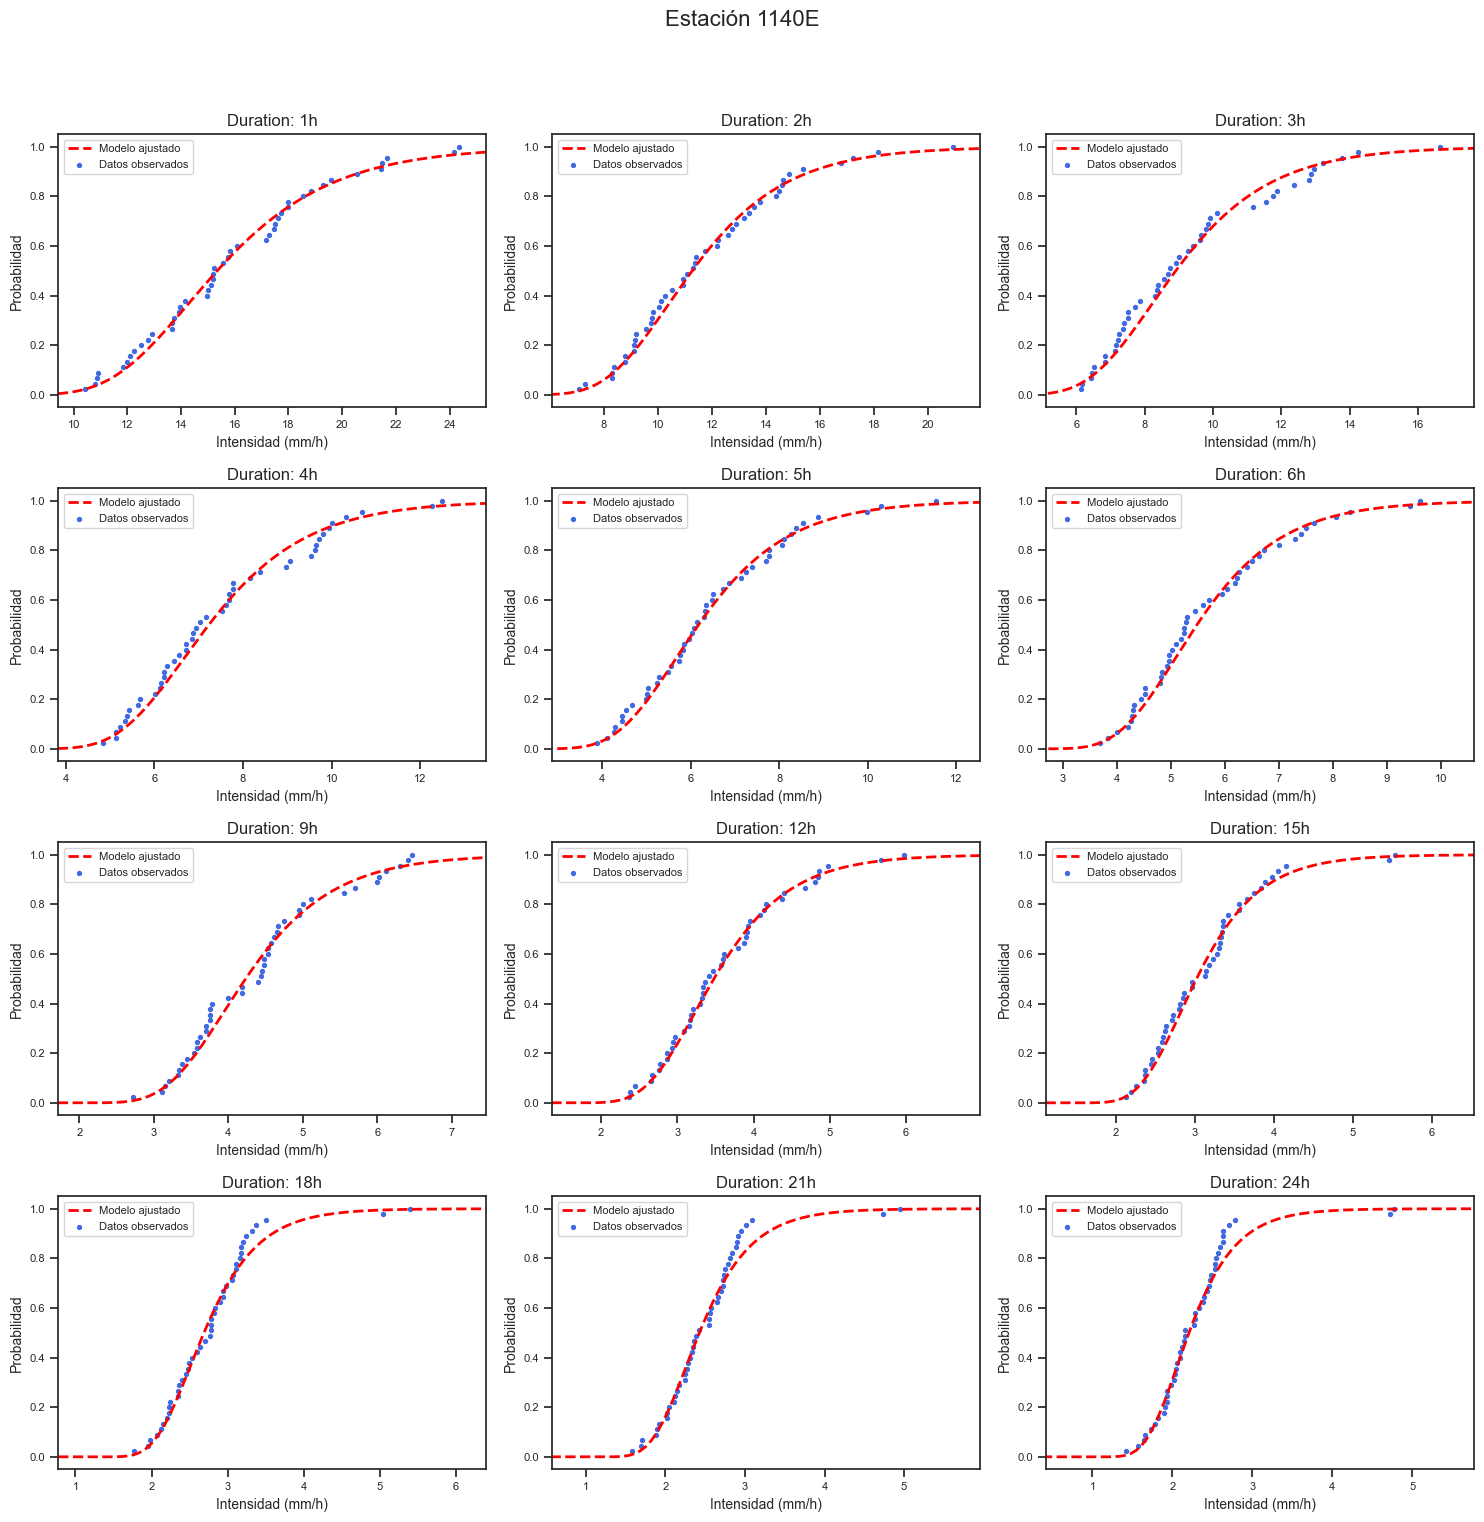

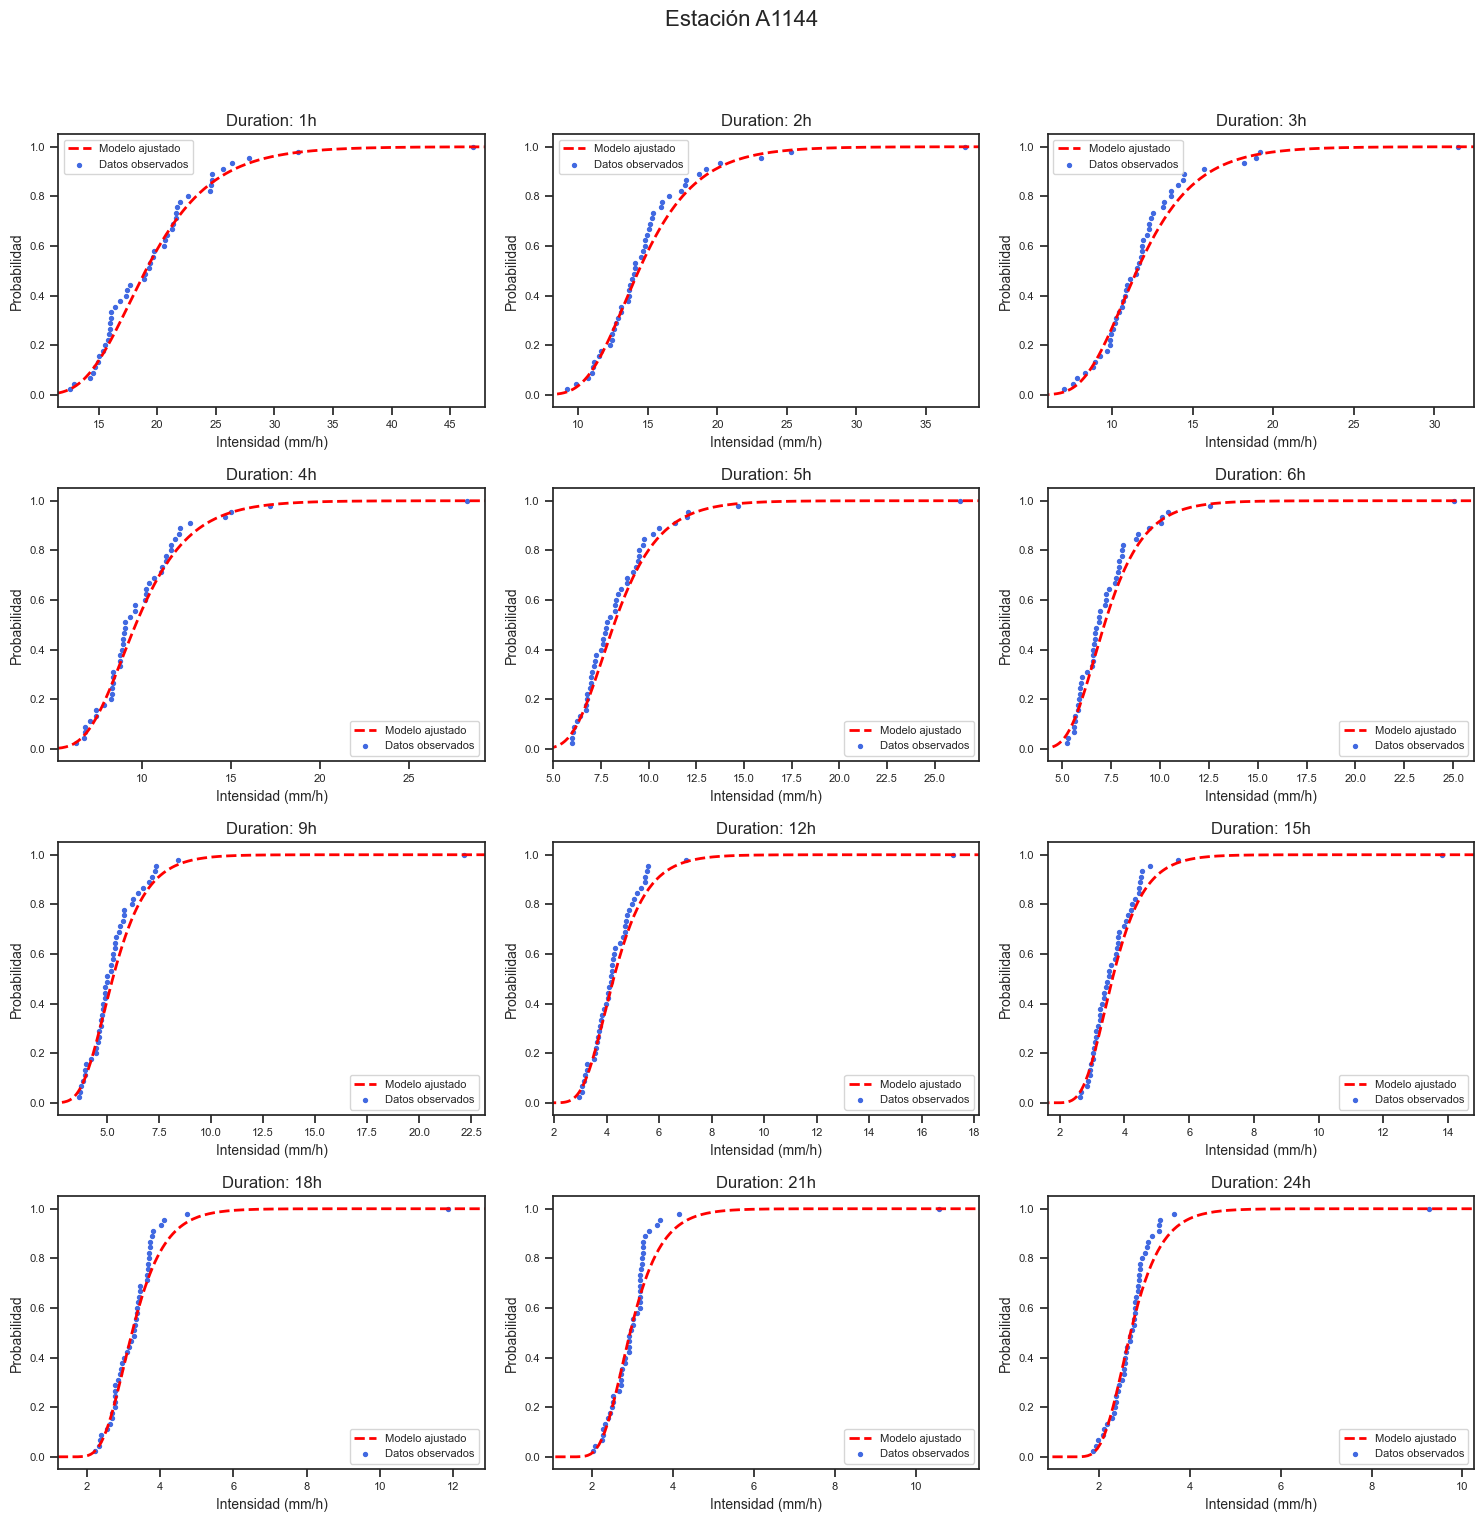

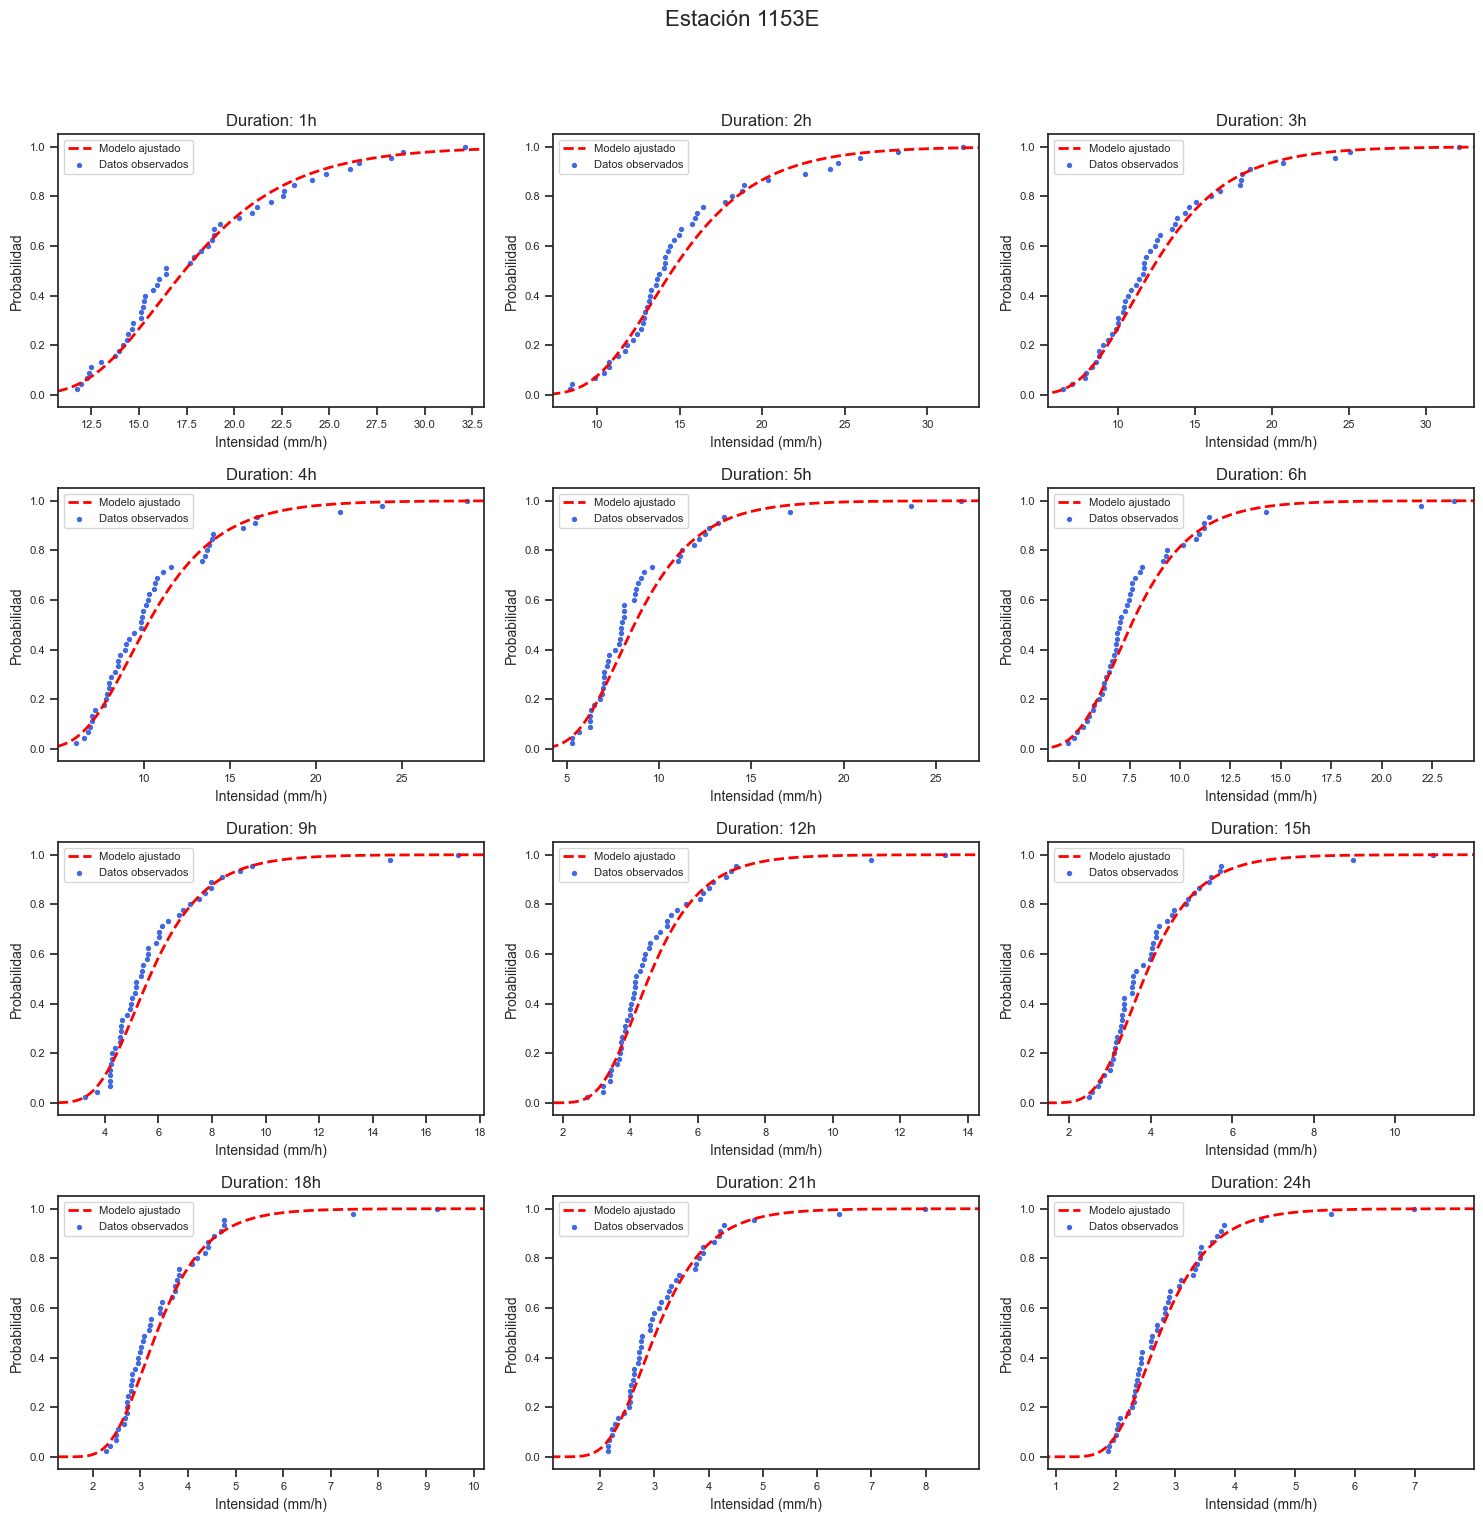

In [325]:
plot_cdf_models(intensity_annual_max_dict, Model_fit_scipy, Durations, historic_hourly)

# Calculo de los eventos de intensidad para diversos periodos de retorno.

In [155]:
historic_hourly.columns

Index(['1121O', '1151', '1140E', 'A1144', '1153E'], dtype='object')

In [258]:
# Define return periods and non exceedance probability
Return_period = np.array([2 ,5 ,10 ,25 ,50 ,100])
Non_Exceedance_Probability = 1 - 1 /Return_period

Gages_idf = {}

for gage in historic_hourly.columns:
    IDF = pd.DataFrame(index=Return_period, columns=Durations)
    IDF.index.name = 'Tr'
    for duracion in Durations:
        parametros = Best_model_fit[gage][duracion]
        IDF.loc[:,duracion] = genextreme(*parametros).ppf(Non_Exceedance_Probability)

    df_sorted = IDF.apply(lambda row: sorted(row, reverse=True), axis=1, result_type='expand')
    df_sorted.columns = IDF.columns    
    Gages_idf[gage] = df_sorted.copy()

In [259]:
Gages_idf['1121O']

1          2          3          4          5          6   \
Tr                                                                      
2    18.686903  15.282928  12.476043  10.486394   8.901648   8.019813   
5    22.911102  18.983414  15.935557  13.168281  11.131149   9.822182   
10   25.541887  21.125954  18.062706  14.760449  12.537001  10.887350   
25   28.688011  23.526703  20.577549  16.584739  14.237061  12.102875   
50   30.900167  25.110454  22.326131  17.814847  15.445499  12.919245   
100  32.998460  26.533851  23.969062  18.941033  16.602334  13.664143   

           9         12        15        18        21        24  
Tr                                                               
2    6.089210  4.965398  4.207310  3.617936  3.190310  2.923531  
5    7.301011  5.916669  4.997947  4.359081  3.947274  3.618803  
10   7.976097  6.487122  5.492977  4.897423  4.575346  4.168092  
25   8.707092  7.146630  6.087810  5.637181  5.550348  4.983166  
50   9.173355  7.595260  6.508016  6.432411  6.232471  5.689377  
100  9.580678  8.009051  7.469381  6.908168  6.865671  6.489478

In [260]:
Gages_idf['1151']

1          2          3          4          5          6   \
Tr                                                                      
2    17.106498  13.964797  11.504072   9.557717   8.252317   7.191721   
5    20.710200  17.367531  14.669348  12.467695  10.965917   9.655597   
10   22.758750  19.418653  16.716360  14.604364  13.022056  11.602162   
25   25.017041  21.800972  19.248601  17.569495  15.958540  14.490640   
50   26.483112  23.428896  21.088865  19.978327  18.410992  16.993346   
100  27.783035  24.936163  22.883903  22.561388  21.103599  19.828808   

            9          12        15        18        21        24  
Tr                                                                 
2     5.251065   4.238514  3.672203  3.299371  2.981262  2.750023  
5     7.000255   5.619226  4.707358  4.207826  3.788064  3.481651  
10    8.404397   6.799060  5.494155  4.879616  4.346131  3.977460  
25   10.518741   8.681127  6.621024  5.817936  5.079693  4.617219  
50   12.376609  10.428574  7.564726  6.584986  5.645186  5.101616  
100  14.506934  12.529152  8.603263  7.411902  6.225107  5.590843

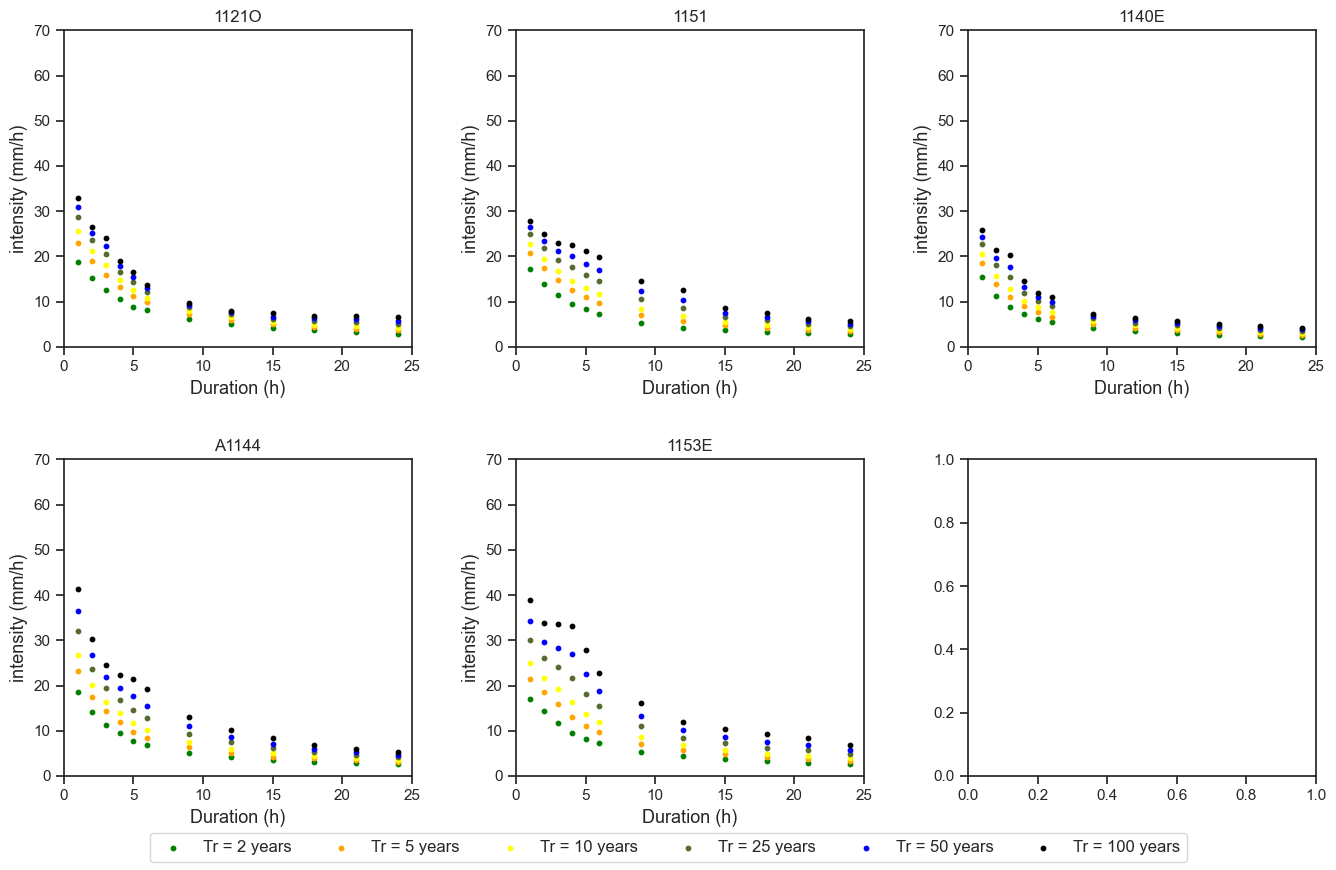

In [261]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 9), sharex=False, sharey=False)

for gage, ax in zip(historic_hourly.columns, axes.flatten()):
    IDFe = Gages_idf[gage]
    
    ax.set_xlabel('Duration (h)', fontsize=13)
    ax.axis(xmin=0, xmax=IDFe.columns.max() + 1)
    ax.set_ylabel('intensity (mm/h)', fontsize=13)
    ax.axis(ymin=0, ymax=70)
    color = ['green', 'orange', 'yellow', 'darkolivegreen', 'blue','black','red']

    for i, Tr in enumerate(Return_period):
        ax.scatter(Durations, IDFe.loc[Tr,:], color=color[i], s=10, label='Tr = ' + str(int(Tr)) + ' years')
        ax.set_title(gage)
    # generar Labels en la parte inferior de la figura
    lines = []
    labels = []
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)
fig.tight_layout(pad=2.5)
fig.legend(lines,labels,loc=8, ncol=7, fontsize=12);

# Ajuste de ecuaciones a las IDF

In [262]:
def Fit_IDF(IDF, title, plot):
    """
    Ajusta curvas IDF sintéticas a datos observados y opcionalmente genera un gráfico comparativo.

    Parameters:
    - IDF: DataFrame con datos observados de curvas IDF.
    - plot: Booleano, True para generar un gráfico, False para no generar.

    Returns:
    - synth_IDF: DataFrame con las curvas IDF sintéticas.
    """
    
    # Función IDF_curve: Define la ecuación de la curva IDF con parámetros a, b, y c
    def IDF_curve(D, a, b, c):
        return a / (D**b + c)
    
     # Función fit_multi_IDF_curves: Ajusta múltiples curvas IDF a los datos observados
    def fit_multi_IDF_curves(x, params):
        y = pd.DataFrame().reindex_like(x)
        for idx, T in enumerate(x.index):
            y.loc[T, :] = IDF_curve(x.loc[T].index.values.astype("float64"), params[idx+1], params[0], params[idx+8])
        return (y-x).values.reshape(-1)**2
    
    # Función residuo: Calcula el residuo total usando la función fit_multi_IDF_curves
    def residuo(params):
        return fit_multi_IDF_curves(IDF, params)
    
    # Función construct_multi_IDFs: Construye múltiples curvas IDF sintéticas
    def construct_multi_IDFs(Ts, Ds, params):

        res = pd.DataFrame(index=Ts, columns=Ds)
        for idx, T in enumerate(res.index):
            res.loc[T,:] = IDF_curve(Ds, params[idx+1], params[0], params[idx+8])
        return res
    
    # Ajuste de curvas utilizando least_squares
    ajuste = least_squares(residuo, x0=1.e-3*np.ones(15))
    # Construcción de curvas IDF sintéticas
    synth_IDF = construct_multi_IDFs(IDF.index, np.linspace(0.01, 24, 101), ajuste.x)
    
    # Transformación de datos para facilitar el análisis
    synth_IDF_m = synth_IDF.melt(ignore_index=False).reset_index()
    synth_IDF_m.columns = ["T", "D", "I"]
    datucos = IDF.melt(ignore_index=False).reset_index()
    datucos.columns = ["T", "D", "I"]
    
    # Generación de gráfico si plot=True
    if plot:
        fig, ax = plt.subplots(figsize=(8, 5))

        colores = mpl.colormaps['viridis'].resampled(7)

        for idx, T in enumerate(IDF.index):
            co = IDF.loc[T,:]
            cs = synth_IDF.loc[T,:]
            ax.scatter(co.index, co.values, color=colores(idx), label=T, s = 12)
            ax.plot(cs.index, cs.values, color=colores(idx))

        ax.legend()
        ax.set_title(title)
        ax.set_xlabel('Duration (h)', fontsize=13)
        ax.set_ylabel('intensity (mm/h)', fontsize=13)
        
    return synth_IDF.T

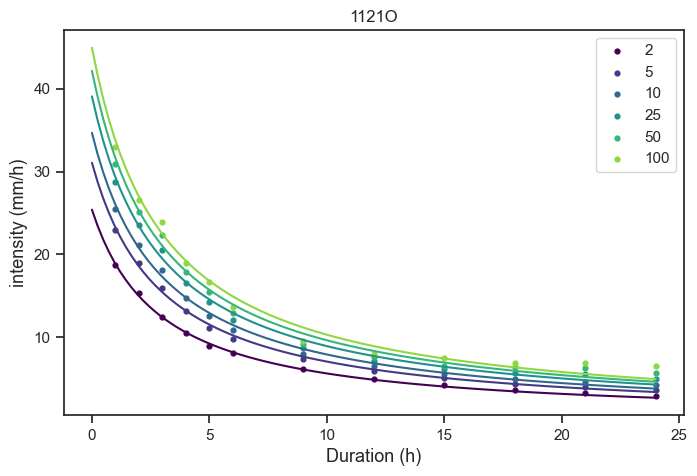

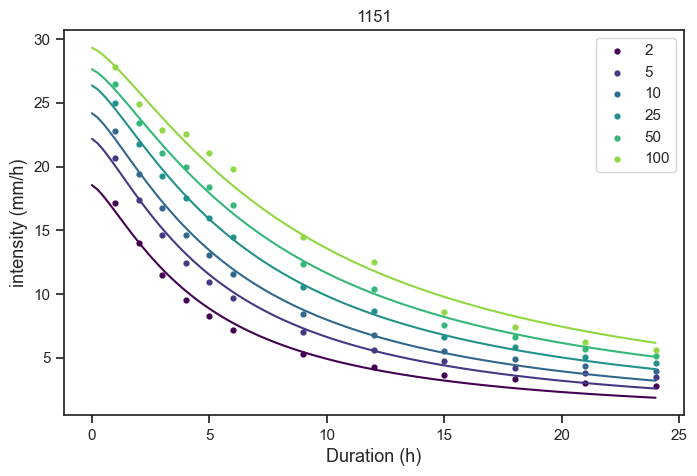

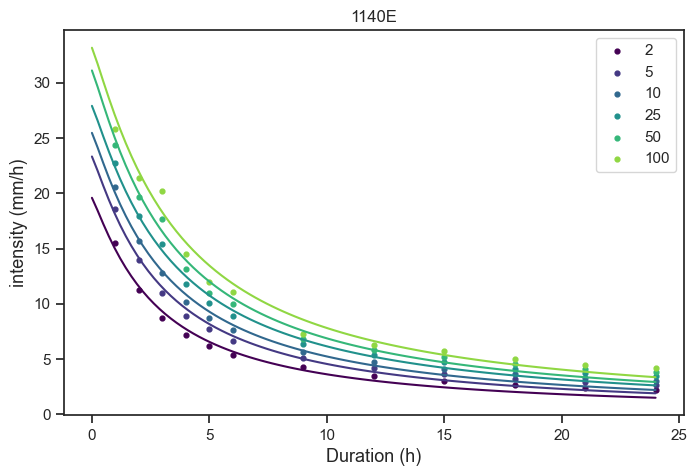

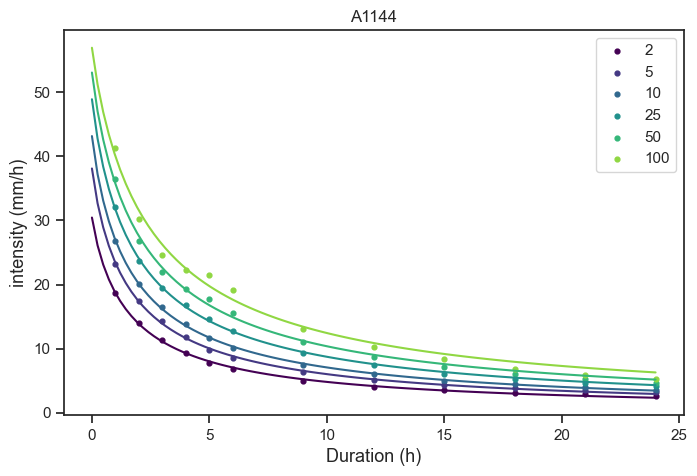

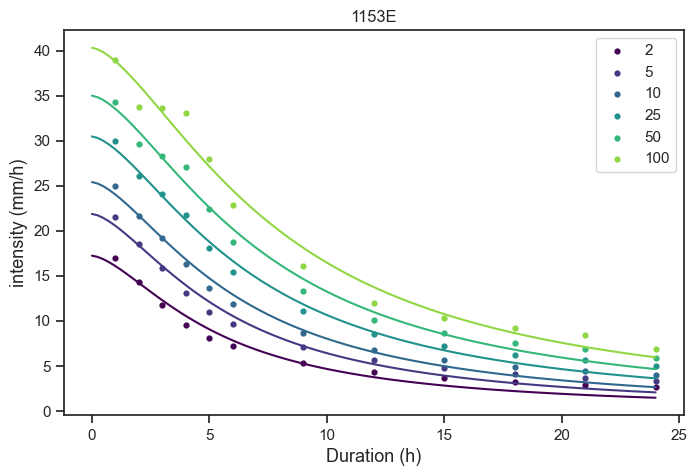

In [263]:
Gages_idf_fit = {}
for gage in historic_hourly.columns:
    Gages_idf_fit[gage] = Fit_IDF(Gages_idf[gage], title = gage, plot = True)

# Generación de hietogramas

## Definición de la duración de la tormenta

La determinación del tiempo de tormenta es fundamental para describir la duración del hietograma de diseño, el tiempo de tormenta debe ser como mínimo el tiempo de concetración de la cuenca. La elección del número ideal de horas sin lluvia entre tormentas para considerar un evento de tormenta como completo depende de varios factores y del contexto específico del análisis. Algunas pautas generales y recomendaciones basadas en prácticas comunes en hidrología:

- Criterios comunes:

Muchos hidrólogos utilizan un rango de 6 a 24 horas sin lluvia significativa para separar eventos de tormenta. El U.S. National Weather Service a menudo usa un criterio de 6 horas sin precipitación para definir el fin de un evento de tormenta. En estudios urbanos, donde las cuencas responden más rápidamente, se pueden usar intervalos más cortos, como 2-4 horas.


- Factores a considerar:

Tamaño y características de la cuenca: Cuencas más grandes generalmente requieren intervalos más largos.
Clima local: En regiones con lluvias frecuentes, podrías usar intervalos más cortos.
Propósito del análisis: Para estudios de inundaciones repentinas, intervalos más cortos; para análisis de recarga de acuíferos, intervalos más largos.


- Recomendación general:

Un buen punto de partida es usar un intervalo de 6 horas sin lluvia significativa entre eventos. Sin embargo, este valor puede ir variando en función de las características específicas del área de estudio y los objetivos de tu análisis.

Para ilustrar cómo diferentes criterios pueden afectar la identificación de eventos de tormenta, veamos una visualización:

<style>
.container {
    display: grid;
    grid-template-columns: repeat(26, 1fr); /* Cambia 19 por el número de columnas necesarias */
    gap: 1px;
    margin-bottom: 20px;
}
.bar {
    width: 100%;
    text-align: center;
    border: 2px solid black;
    color: black;
    height: 40px;
}

.storm {
    background-color: skyblue;
    text-align: center;
    padding: 5px;
    border: 1px solid black;
}
</style>

<h3>Datos de precipitación (mm/hora)</h3>
<div class="container">
    <div class="bar"><div style="height: 40px; background-color: skyblue;">5</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">8</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">3</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">7</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">12</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">4</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">6</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">9</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">2</div></div>
</div>

<h3>Criterio: 2 horas consecutivas sin lluvia</h3>
<div class="container">
    <div class="bar"><div style="height: 40px; background-color: skyblue;">5</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">8</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">3</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">7</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">12</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">4</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">6</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">9</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">2</div></div>
</div>

<h3>Criterio: 4 horas sin lluvia</h3>
<div class="container">
    <div class="bar"><div style="height: 40px; background-color: skyblue;">5</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">8</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">3</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: white;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">7</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">12</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">4</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">6</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">9</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">2</div></div>
</div>

<h3>Criterio: 6 horas sin lluvia</h3>
<div class="container">
    <div class="bar"><div style="height: 40px; background-color: skyblue;">5</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">8</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">3</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">7</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">12</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">4</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">6</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">9</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">0</div></div>
    <div class="bar"><div style="height: 40px; background-color: skyblue;">2</div></div>
</div>

En el gráfico anterior, se puede ver en azul, las tormentas que se unen considerando distintos periodos sin lluvia. A continuación dejamos un ejemplo de lo que se puede realizar con la librería ``RainfallAnalyzer``.

In [195]:
historic_hourly = pd.read_csv('E:/FLOOD/Nbooks/data/all_gages.csv', index_col = 0, parse_dates=True)
historic_hourly

1121O  1151     1140E     A1144  1153E
date                                                       
1700-01-01 00:00:00    0.0   0.0  0.000000  0.000000    0.0
1700-01-01 01:00:00    0.0   0.0  0.000000  0.000000    0.0
1700-01-01 02:00:00    0.0   0.0  0.000000  0.000000    0.0
1700-01-01 03:00:00    0.0   0.0  0.000000  0.000000    0.0
1700-01-01 04:00:00    0.0   0.0  0.000000  0.000000    0.0
...                    ...   ...       ...       ...    ...
2200-12-30 18:00:00    0.0   0.0  2.301749  1.277769    0.0
2200-12-30 19:00:00    0.0   0.0  0.000000  0.000000    0.0
2200-12-30 20:00:00    0.0   0.0  0.000000  0.000000    0.0
2200-12-30 21:00:00    0.0   0.0  0.000000  1.694104    0.0
2200-12-30 22:00:00    0.0   0.0  0.000000  0.000000    0.0

[4391639 rows x 5 columns]

En la función ``RainfallAnalyzer`` los argumentos de entrada que se deben considerar son:
- ``max_gap``: Corresponde al intervalo máximo de separación de ceros ne horas que se debe considerar para unir dos tormentas.
- ``umbral``: umbral en mm que considera si hay o no precipitación. Este parámetro ayuda a que los valores de lluvia horarios bajos (0.01 por ejemplo) se tomen como ceros y no afecten el análisis.

In [196]:
df = historic_hourly[['1121O']]

In [197]:
# Threshold and maximum gap definition
processor = RainDataProcessor(umbral=1, max_gap=0)

En este caso, se definirán 3 tormentas. La primera tormenta definida como ``storm_1`` se define como la tormenta con mayor duración para un ``umbral`` y ``max_gap`` específico. La segunda tormenta, definida como ``storm_2`` se define será entonces la segunda tormenta crítica observada y asi sucesivamente hasta llegar al número de tormentas definido por el usuario. 

In [198]:
# Analizar múltiples tormentas
result_storms = processor.analyze_multiple_storms(df, num_storms=10)
result_storms

P_max      P_acum duration (h)  \
storm_1   21.238256  198.137735           27   
storm_2   11.566557  157.590288           26   
storm_3   27.154562  162.835611           23   
storm_4    21.63994  174.250186           23   
storm_5   15.385033  112.273907           23   
storm_6   13.459305  135.664111           22   
storm_7   12.948908   116.58617           22   
storm_8   17.897122  143.692129           21   
storm_9   20.263241   176.63449           21   
storm_10  17.197363  148.319784           21   

                                                  data_base  
storm_1                           lluvia
date           ...  
storm_2                           lluvia
date           ...  
storm_3                           lluvia
date           ...  
storm_4                           lluvia
date           ...  
storm_5                           lluvia
date           ...  
storm_6                           lluvia
date           ...  
storm_7                           lluvia
date           ...  
storm_8                           lluvia
date           ...  
storm_9                           lluvia
date           ...  
storm_10                          lluvia
date           ...

Además de la duración, en la tabla anterior, se pueden ver el ``P_max`` que se describe como el valor máximo observado para cada tormenta. El ``P_acum``, que será la precipitación total acumulada de cada tormenta y la ``duration (h)``, que se define como la duración de cada evento. El gráfico de cada tormenta se puede ver utilizando la función ``plot_storm``.

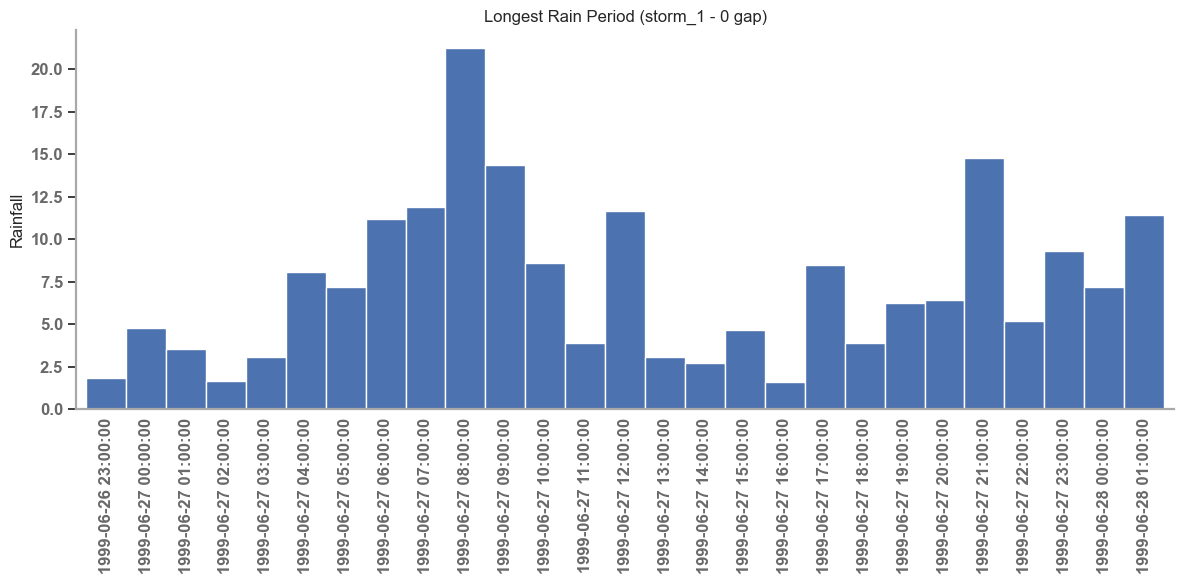

In [199]:
# Plot data
processor.plot_storm('storm_1')

# Análisis de tiempo de tormentas

Vamos a analizar para diferentes valores de separación máxima entre tormentas, para analizar el tiempo que puede durar una tormenta en los datos sintéticos de lluvia previamente generados.

In [200]:
# Time of concentration (Tc) hours (Spain equation)
tc = 14.089

In [201]:
historic_hourly.columns

Index(['1121O', '1151', '1140E', 'A1144', '1153E'], dtype='object')

In [202]:
df = historic_hourly[['1140E']]

In [203]:
# Threshold and maximum gap definition
processor = RainDataProcessor(umbral=2, max_gap=0)
result_storms = processor.analyze_multiple_storms(df, num_storms=3)
result_storms

P_max      P_acum duration (h)  \
storm_1  63.617691  487.459649           37   
storm_2  15.217394  153.944018           21   
storm_3  37.978498  163.882372           19   

                                                 data_base  
storm_1                          lluvia
date           ...  
storm_2                          lluvia
date           ...  
storm_3                          lluvia
date           ...

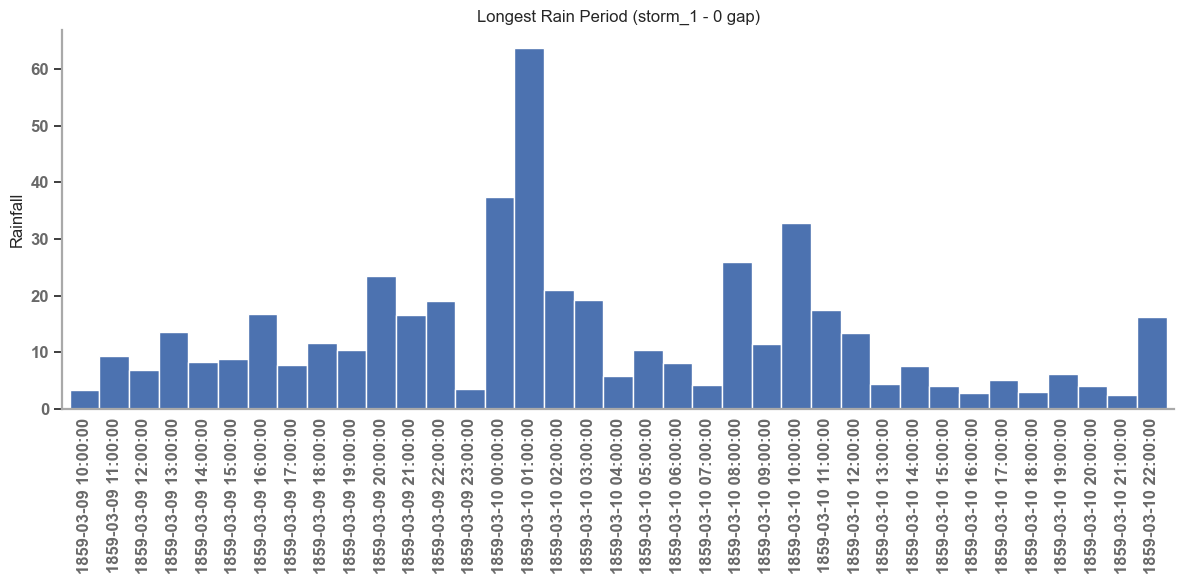

In [204]:
processor.plot_storm('storm_1')

In [205]:
def hietograma(data, title, fle, plot):
    
    """
    Function to calculate hydrograms using the Artner blocks method.
    
    Parameters:
    - data: pd.DataFrame
        Contains IDF (Intesity-Duration-Frequency) curves for a specific region.
    - fle: factor lluvia espacial

    Note: The index of 'data' should represent time in hours.

    Returns:
    pd.DataFrame
        Hydrogram calculated using the Artner blocks method.

    Example:
    -------
    hydrogram = hietograma(idf_data)

    Explanation:
    ------------
    This function takes a DataFrame 'data' containing IDF curves for a specific region and calculates
    the hydrogram using the Artner blocks method.

    Steps:
    1. Create a DataFrame 'Curva_masa' to store the mass curve, initialized with zeros.
    2. Calculate the mass by multiplying the intensity with time and update 'Curva_masa'.
    3. Sort 'Curva_masa' in ascending order based on the index.
    4. Index transformation to represent intervals in the format "start-end".
    5. Calculate the increments in mass and sort them alternately in 'hietogram'.
    6. Return the resulting hydrogram.

    Note: The Artner blocks method is a technique used in hydrology to convert rainfall intensity data
    into a hydrograph, which represents the flow of water over time in a particular watershed.
    """
    hietogramas = pd.DataFrame()
    
    for col in data.columns:
        # Step 1: Create a DataFrame to store the mass curve
        Curva_masa = pd.DataFrame(index=data.index, columns=['Masa'])

        # Step 2: Calculate mass by multiplying intensity with time
        Curva_masa['Masa'] = data[col] * data.index
        Curva_masa.loc[0, 'Masa'] = 0

        # Step 3: Sort the mass curve in ascending order based on the index
        Curva_masa.sort_index(ascending=True, inplace=True)

        # Step 4: Transform the index to represent intervals in the format "start-end"
        Curva_masa.index = [f"{Curva_masa.index[i]:.3f}-{Curva_masa.index[i+1]:.3f}" for i in range(len(Curva_masa)-1)] + [f"{Curva_masa.index[-1]:.6f}"]

        # Step 5: Calculate increments in mass
        incrementos = Curva_masa[['Masa']].diff().shift(-1).dropna()

        # Step 6: Sort increments alternately in 'hietogram'
        hietogram = pd.DataFrame()
        hietogram['Masa'] = sorted(incrementos['Masa'][::2]) + sorted(incrementos['Masa'][1::2], reverse=True)
        hietogram.index = incrementos.index
        hietogram.dropna(inplace=True)
        hietogram.rename(columns={"Masa": col}, inplace = True)
        # step 7 concat 
        hietogramas = pd.concat([hietogramas, hietogram], axis = 1)*fle 
    
    if plot:
        sns.set(style = 'dark')
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8), sharex = False, sharey = False, dpi = 120)
        color = mpl.colormaps['viridis'].resampled(7)

        for nn, ax, c in zip(hietogramas.columns, axes.flatten(), range(7)):
            ax.set_xlabel('Time (h)', fontsize=13)
            ax.set_ylabel('Precipitation (mm)', fontsize=13)
            ax.set_title(str(nn)+' Años',fontsize = 14, color = '0.2')
            ax.bar(range(len(hietogramas)), hietogramas.loc[:,nn], color = color(c), width= 1)
   
            # Add labels for axis x
            step = 8  # Intervalo de etiquetas en el eje x, por ejemplo, cada 5 horas
            hora_labels = [f"{int(float(label.split('-')[0])):02d}:00" for label in hietogramas.index]  # Extraer solo la hora  # Extraer solo la hora
            ax.set_xticks(range(0, len(hietogramas), step))
            ax.set_xticklabels(hora_labels[::step], rotation=90, ha='right')
            
            # generar Labels en la parte inferior de la figura
            lines = []
            labels = []
            axLine, axLabel = ax.get_legend_handles_labels()
            lines.extend(axLine)
            labels.extend(axLabel)

        fig.tight_layout(pad=3)
        fig.suptitle('HIETOGRAMAS '+ title, fontsize=16, fontweight='bold');
            
    return hietogramas

## Factor de lluvia espacial 

In [206]:
# Time of concentration (Tc) hours (Spain equation)
tc = 14.089
# Total basin area (km²)
area = 467.7462499994
# Spain formula (Temez)
Temez = (1-np.log10(area)/15)
# Institution of civil engineers (England)
ICEP =1-0.0268*((tc/60)**-0.261)*area**0.387
# Ecuación de Fhrüling
fhruling = 1-0.0054*(area*1000000)**0.25
# Formula de Norte america
NA = 1-0.05*((tc)**0.361)*area**0.264
fle_ = (ICEP+fhruling+NA+Temez)/4
fle_

0.48673744349768056

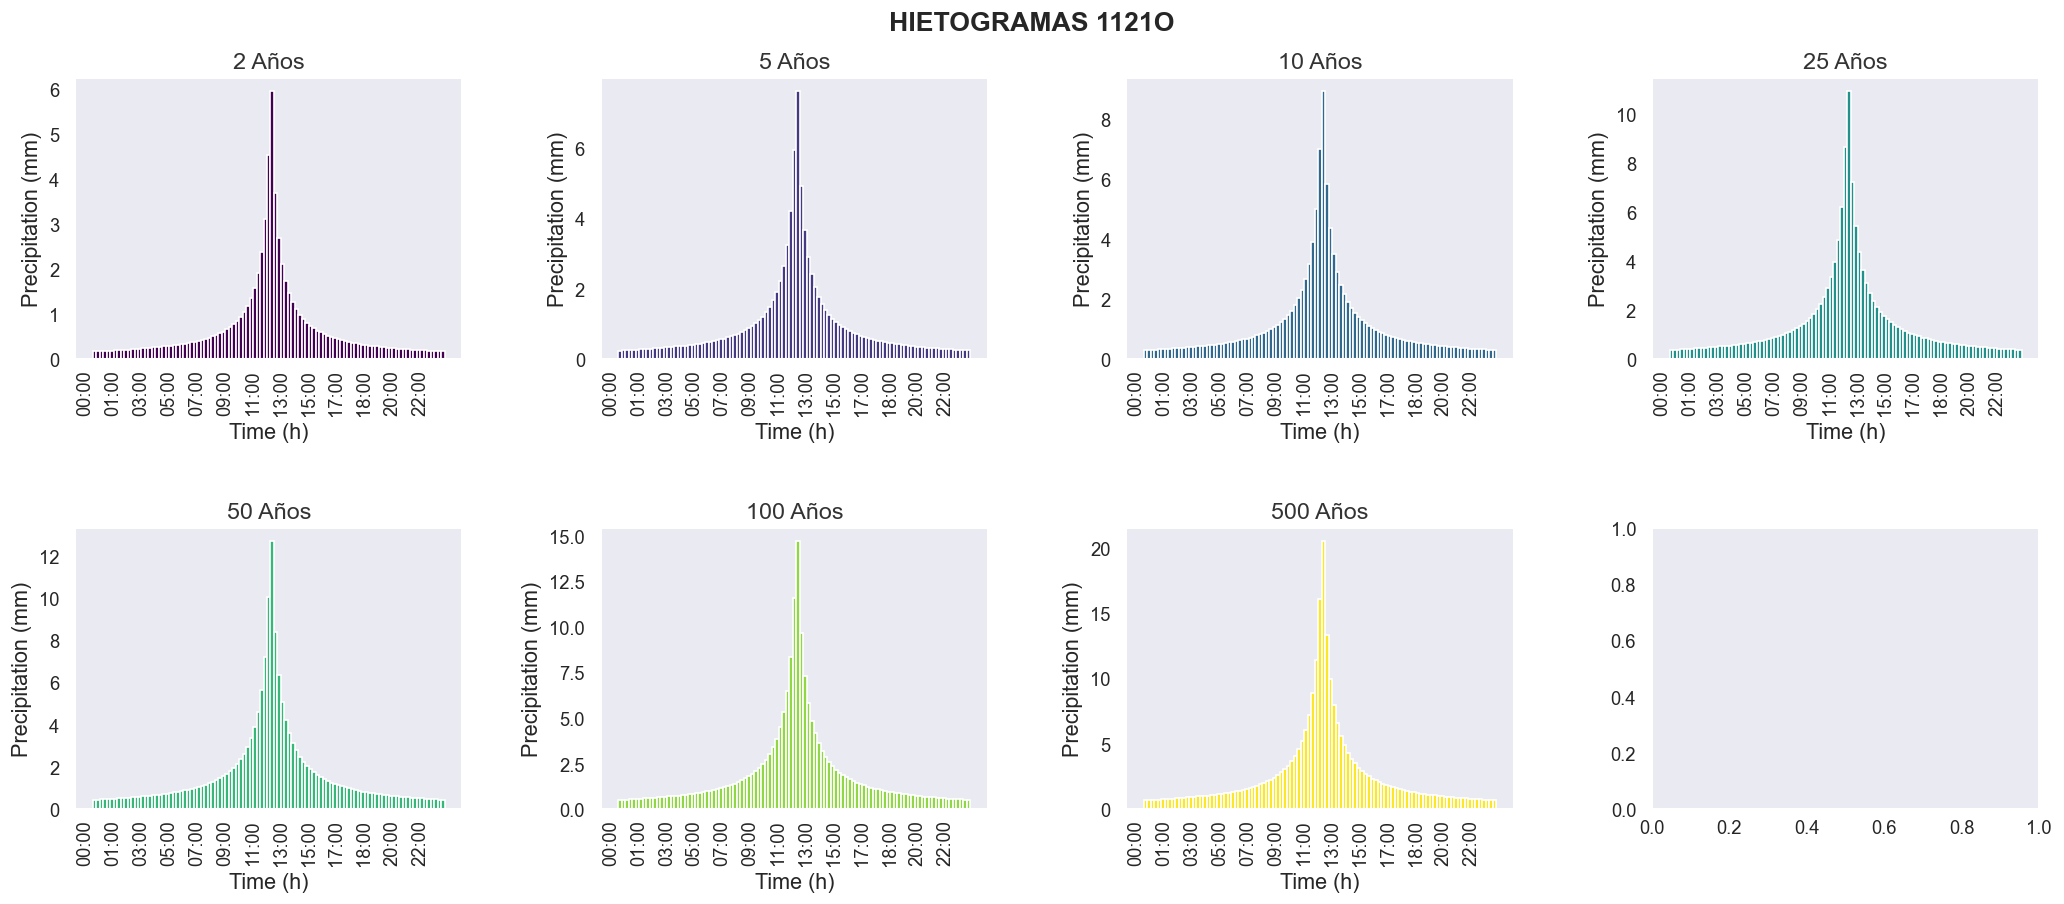

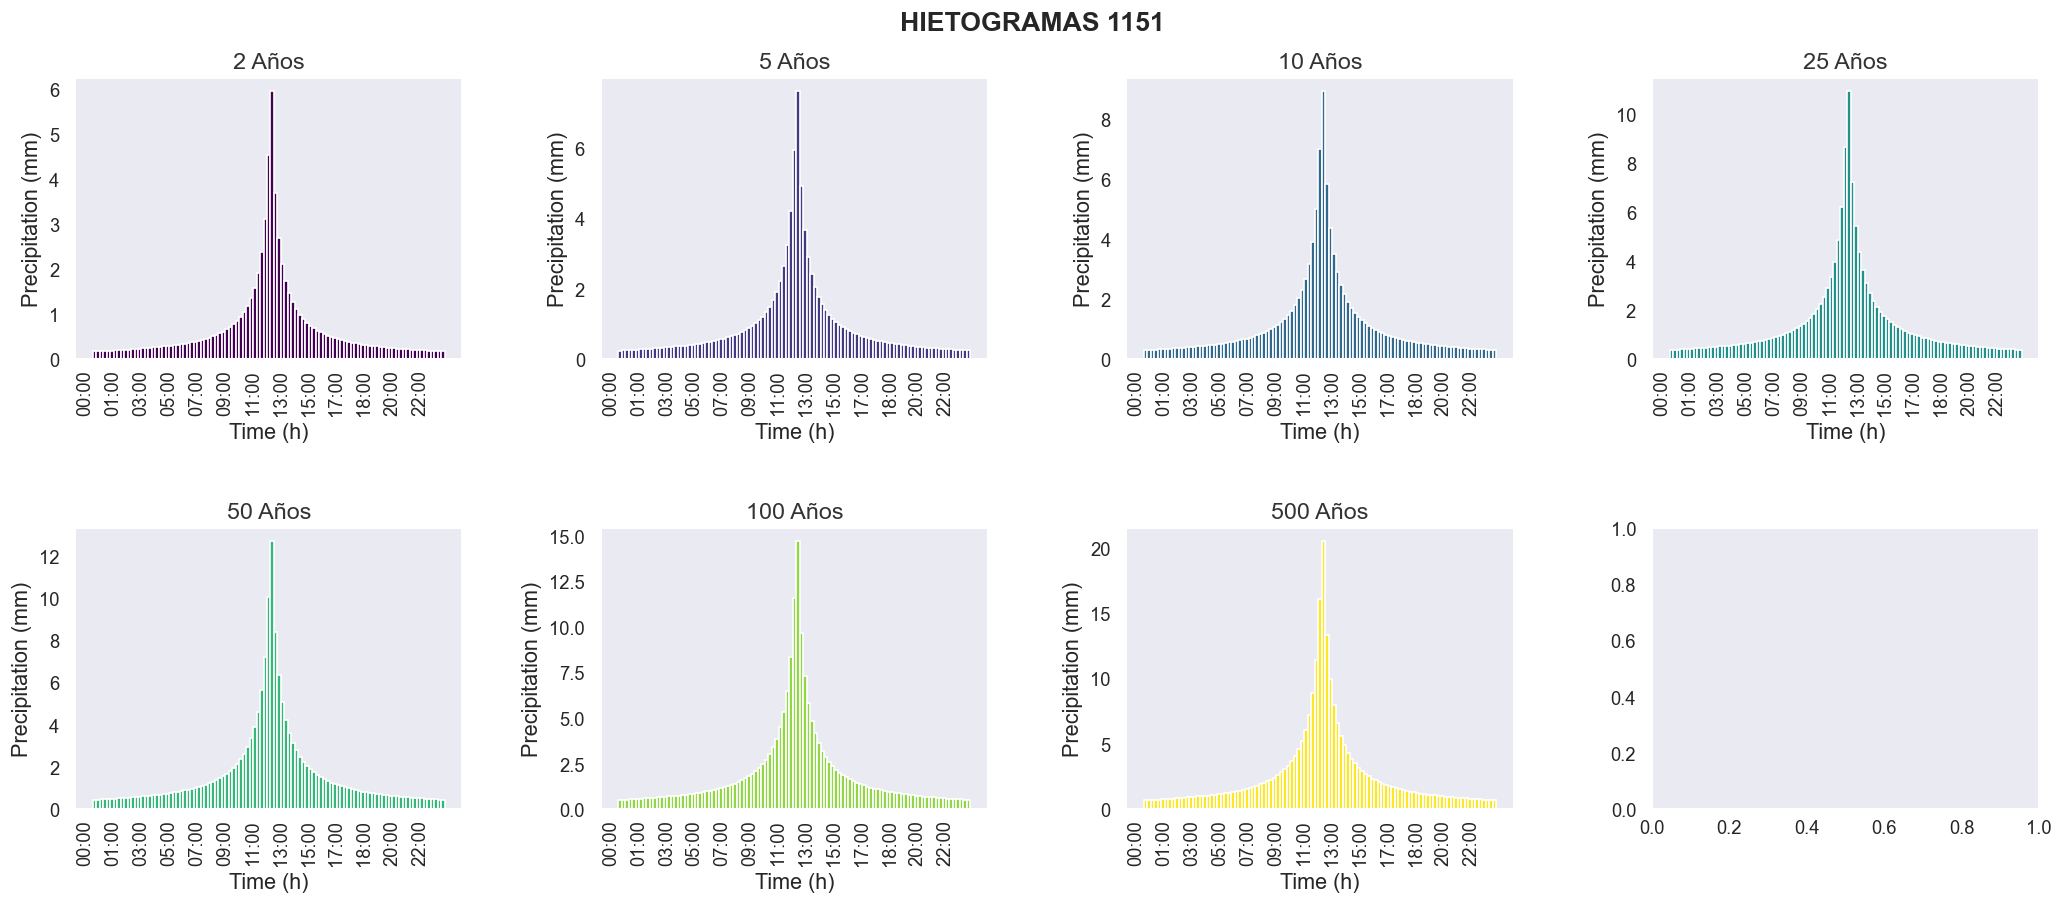

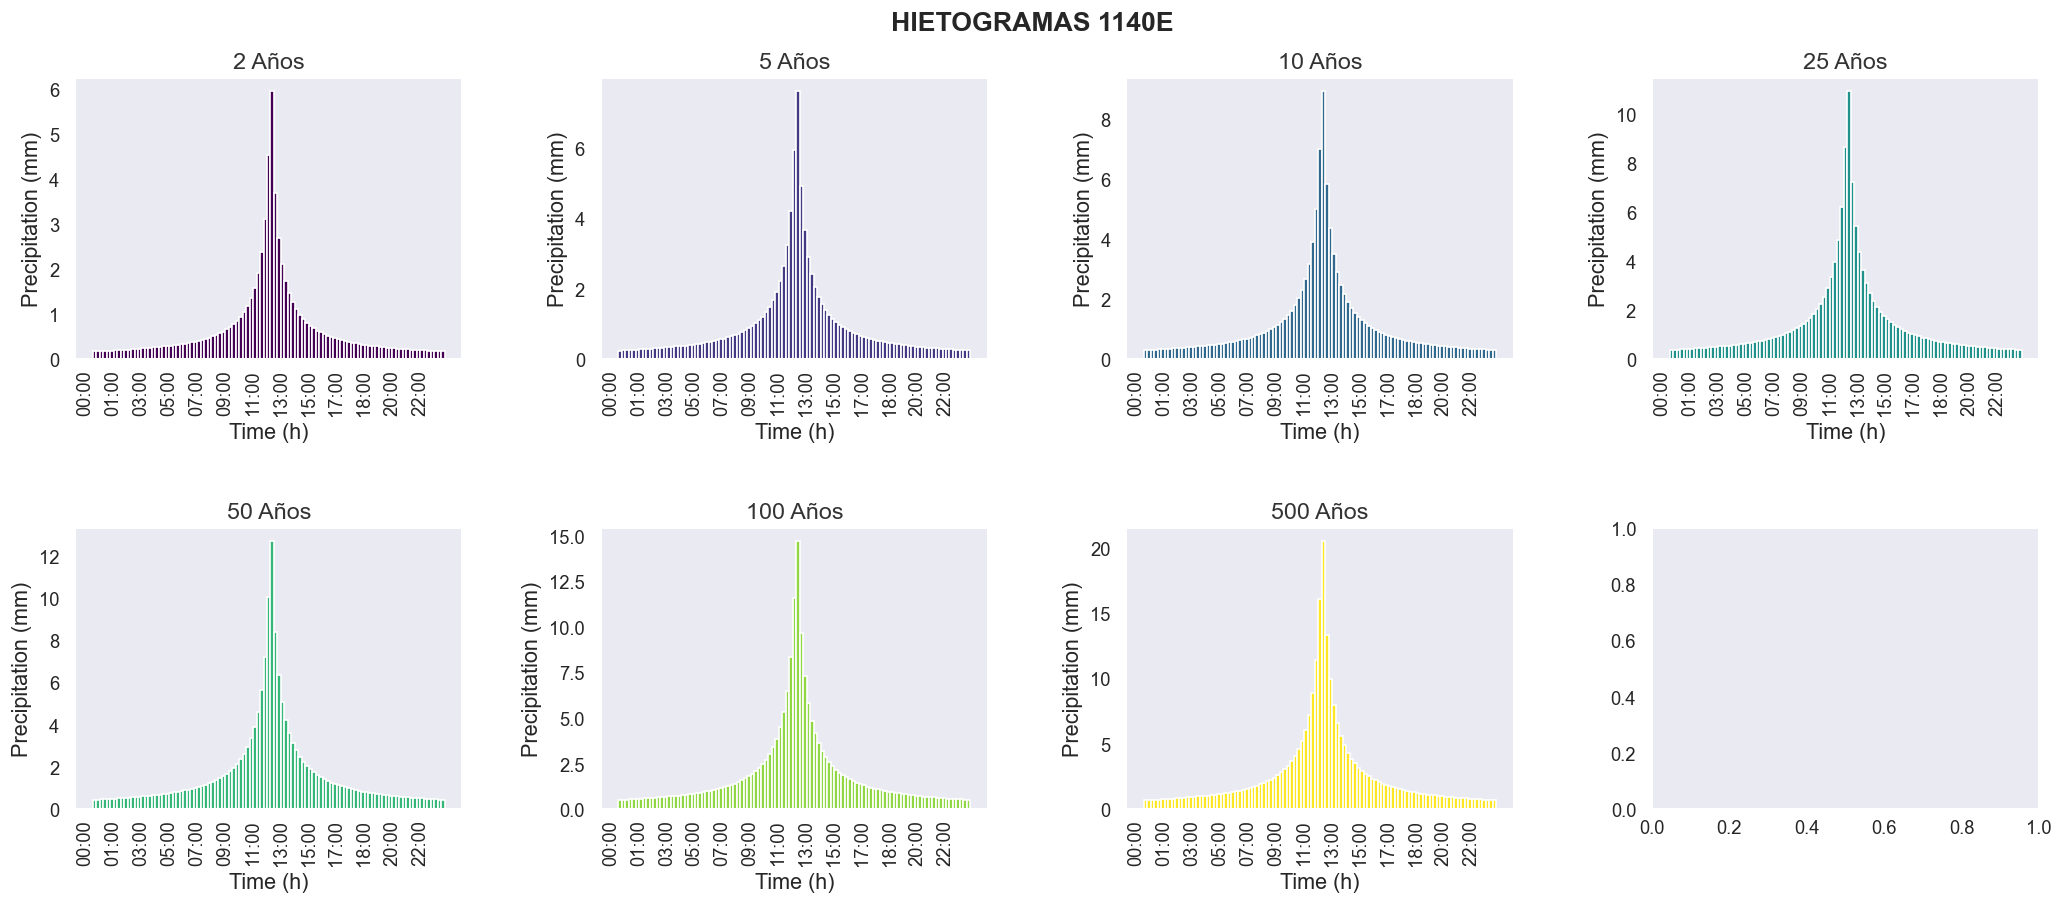

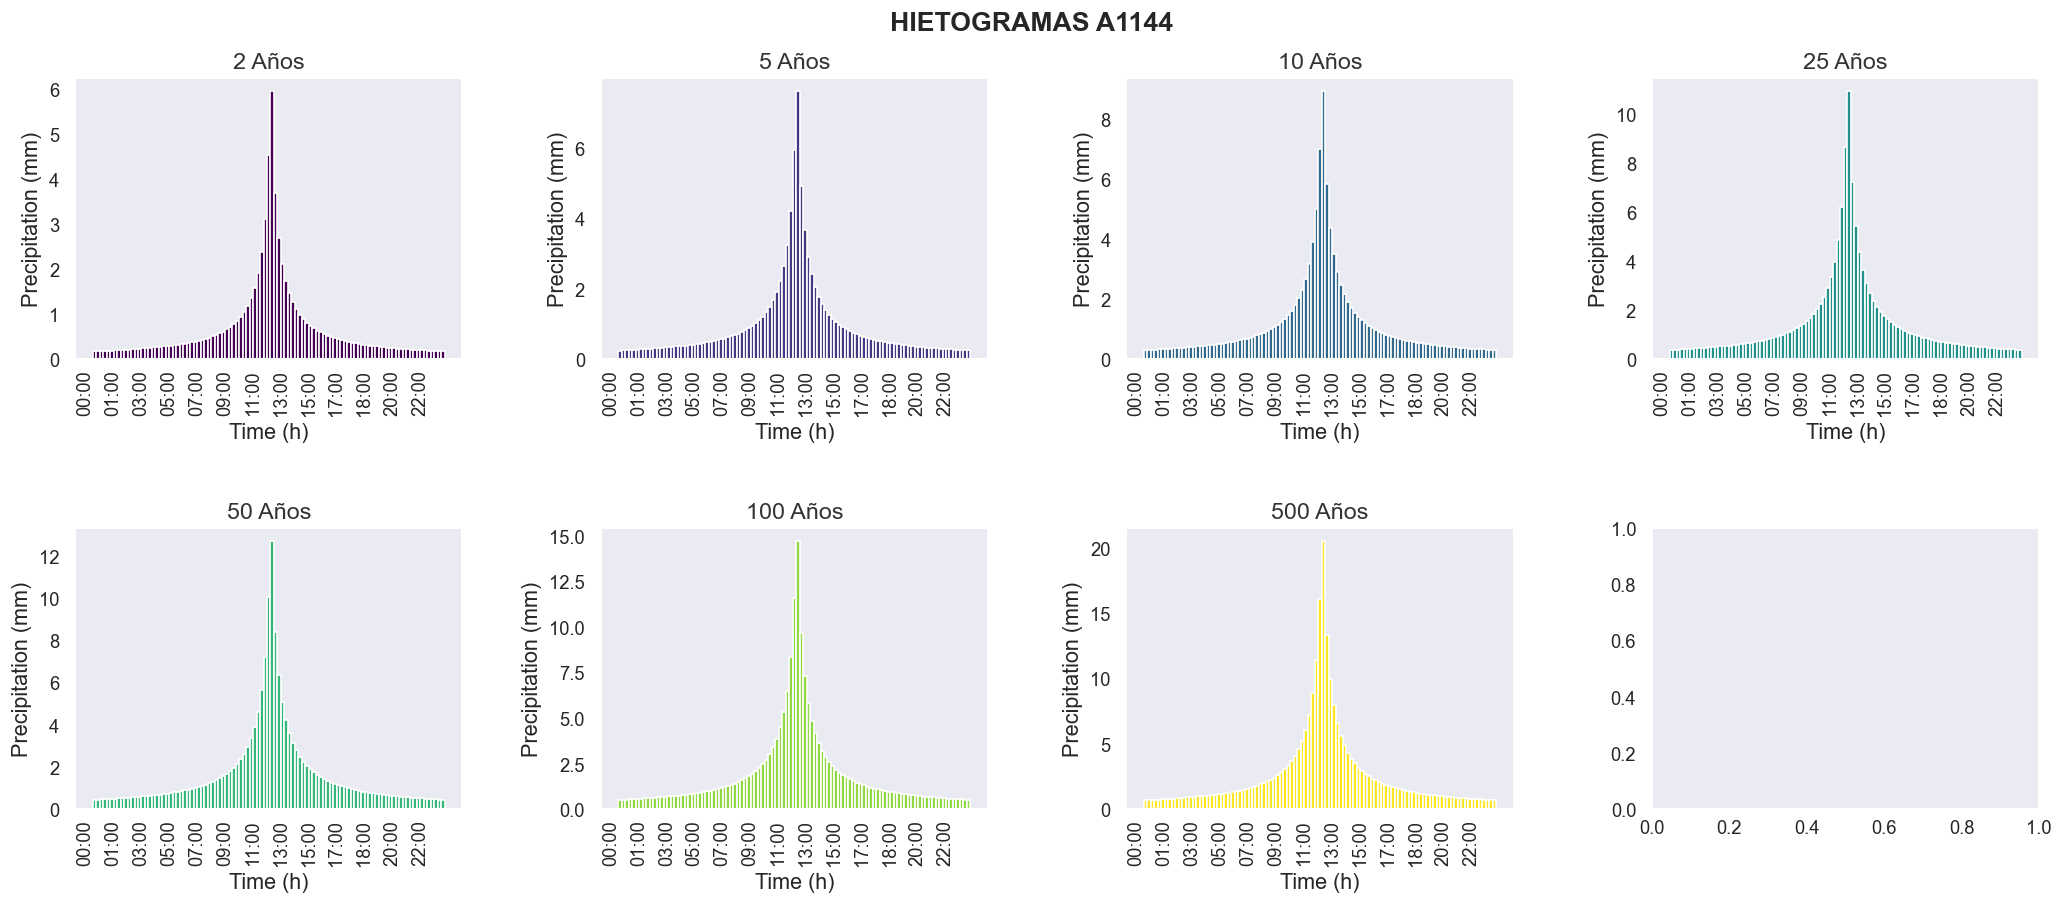

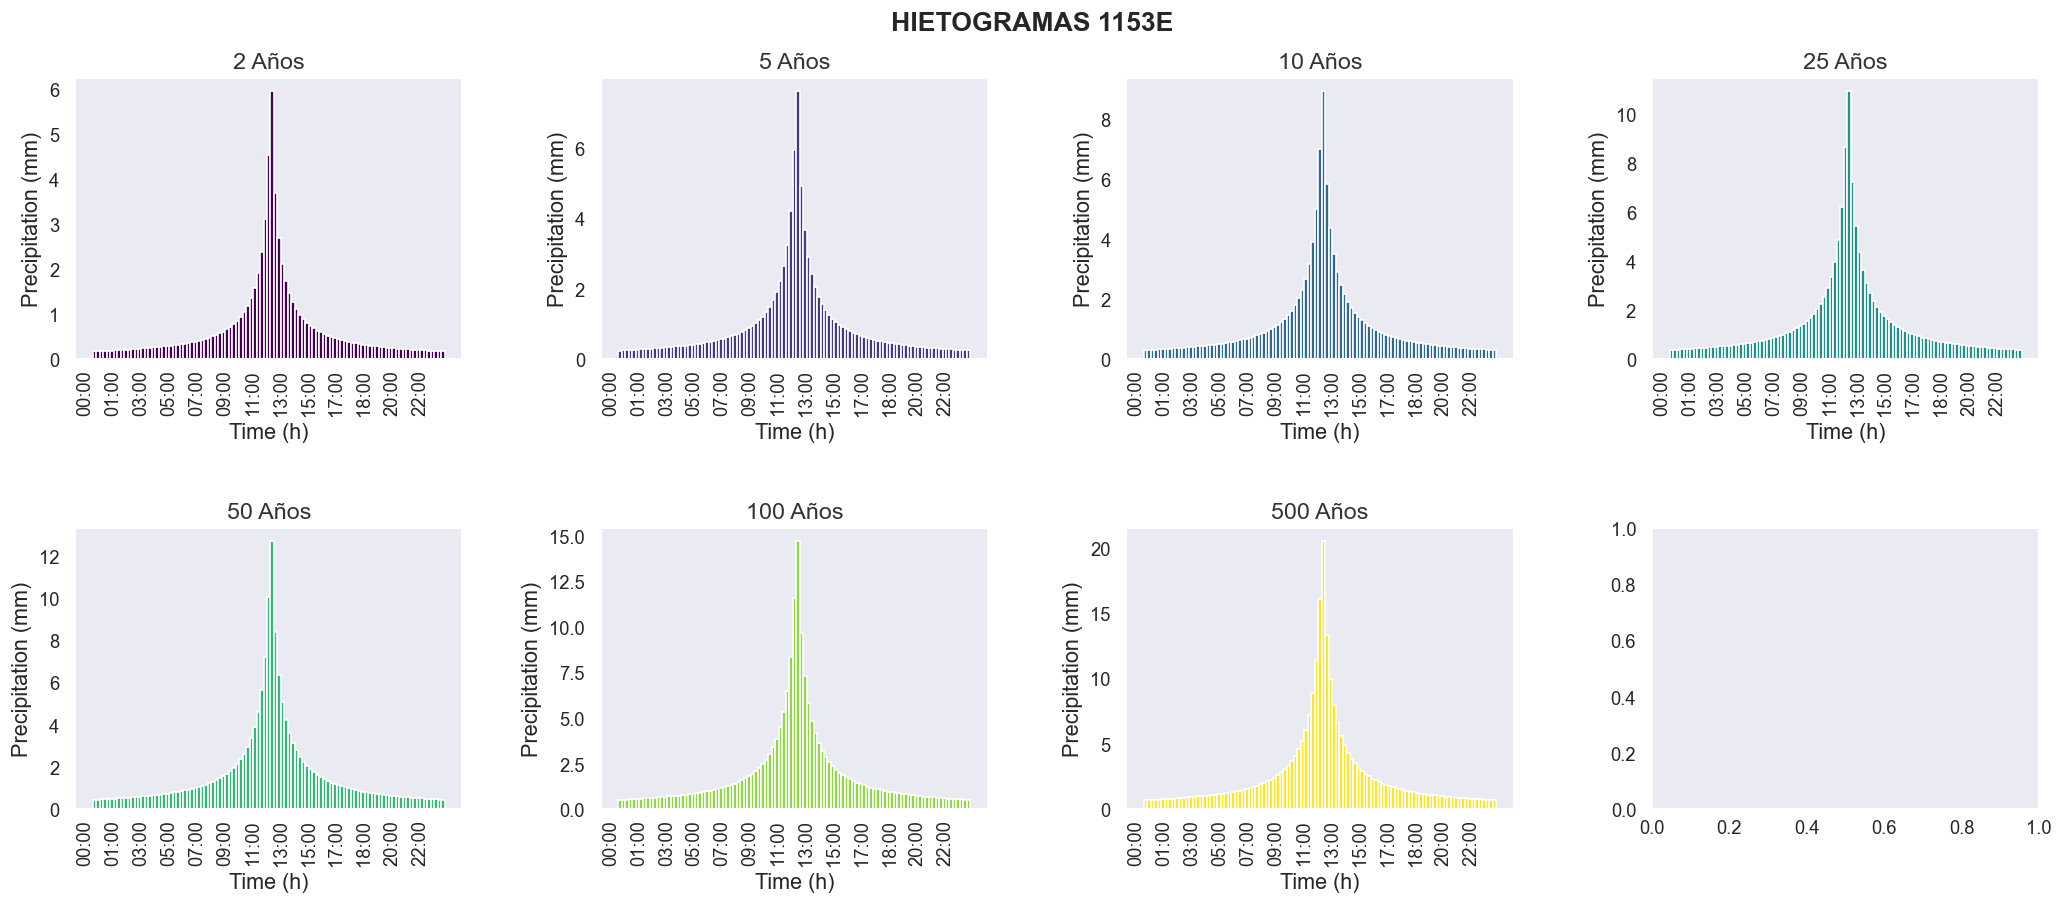

In [207]:
factor_lluvia_espacial = []
for keys in Gages_idf_fit.keys():
    hieto = hietograma(Gages_idf_fit[keys], title = keys, fle=1, plot=True)
    hieto.to_csv(f'E:/FLOOD/Nbooks/data/Hietograms/historic/{keys}.csv')

In [208]:
Gages_idf_fit['1121O'].iloc[:50, :].sum()

Tr
2       481.541391
5       643.655587
10      768.711342
25      950.189492
50     1104.023707
100     1274.91525
500     1752.64211
dtype: object

In [182]:
Gages_idf_fit['1121O'].iloc[:50, :].sum()

Tr
2        497.33556
5       662.802055
10      789.916361
25      973.738557
50     1129.516386
100    1303.106644
500    1786.097673
dtype: object